# Simulated Annealing with $k$-Means Clustering for TSP
Krehbiel, Updated May 2024

## Section 1: Setup
Load libraries and data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time

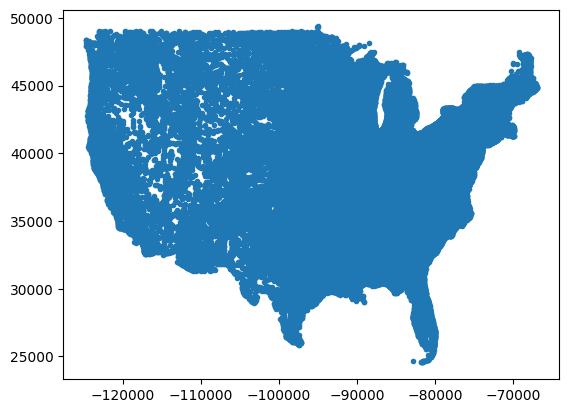

In [2]:
with open("cities.csv") as datafile:
    data = np.loadtxt(datafile, delimiter=" ")[:,1:] # chop off city indices

N = len(data) # number of cities in datafile

# prepare 2D array so (CITIES[i,0],CITIES[i,1]) gives (x,y) coordinates for city i
CITIES = np.zeros((N,2))
CITIES[:,0] = -data[:,1]
CITIES[:,1] = data[:,0]
    
plt.plot(CITIES[:,0],CITIES[:,1],'.');

## Section 2: Utility functions
Functions shared across multiple phases of the solution, e.g., for calculating the distance between cities, tour length, producing a list of cities sorted by tour, swapping, getting random pairs, etc.

In [3]:
# distance between city_i and city_j
def dist(city_i,city_j):
    return math.sqrt((city_i[0]-city_j[0])**2 + (city_i[1]-city_j[1])**2)

# assuming tour is a permutation of the integers {0,...,N-1}, calculate associated tour length
def tour_length(cities,tour):
    n = len(cities)
    length = 0
    for i in range(1,n): # add dist(i-1,i)
        length += dist(cities[tour[i-1],:],cities[tour[i],:])
    return length + dist(cities[tour[0],:],cities[tour[n-1],:])

def tour_length_parallel(cities, tour):
    n = len(cities)
    sum = 0
    lengths = Parallel(n_jobs=-2)(delayed(dist)(cities[tour[i-1],:],cities[tour[i],:]) for i in range(1, n))
    for length in lengths:
        sum += length
    return sum + dist(cities[tour[0],:],cities[tour[n-1],:])

# return cities sorted by the indices specified in tour, e.g., (c0,c1,c2,c3),(0,2,1,3) --> (c0,c2,c1,c3)
def sorted_by_tour(cities,tour):
    n = len(cities)
    city_tour = np.zeros((n,2))
    for i in range(n):
        city_tour[i,:] = cities[tour[i],:]
    return city_tour

# swaps two values in arr, based on the indices specified by pair
def swap(arr,pair):
    o_i = arr[pair[0]]
    arr[pair[0]]=arr[pair[1]]
    arr[pair[1]]=o_i

# returns a uniformly random pair of distinct indices 1,...,n-1
def random_pair(n):
    i = j = np.random.randint(1,n)
    while i==j:
        j = np.random.randint(1,n)
    return i,j

# checks that no single swap improves the given tour
def is_local_opt(cities,tour):
    curr = tour_length(cities,tour)
    for i in range(1,len(cities)):
        for j in range(1,i):
            p=(i,j)
            swap(tour,p)
            if tour_length(cities,tour)<curr:
                return False
            swap(tour,p)
    return True

## Section 3: Clustering
Code for k-means clustering to pre-partition the 115k cities into 300 groups.

In [4]:
# pick k distinct random cities and return their locations
def initial_means(cities,k):
    indices = np.array(range(k))
    for i in range(k):
        j = np.random.randint(len(cities)) # random city
        while sum(np.where(j==indices,indices,0))>0: # keep sampling if not distinct
            j = np.random.randint(len(cities))        
        indices[i]=j
    return cities[indices,:]

# update the k centroids based on assignments
def update_centroids(cities,means,assignment):
    for m in range(len(means)):
        n_m = sum(np.where(assignment==m,1,0)) # number of cities in cluster m
        if n_m>0: # keep the mean of any empty cluster where it is
            x_sum = sum(np.where(assignment==m,cities[:,0],0))
            y_sum = sum(np.where(assignment==m,cities[:,1],0))
            means[m] = np.array([x_sum,y_sum])/n_m
    return means

# greedily move every city to its closest mean and report if any moves occurred
def update_assignments(cities,means,assignment):
    changed = False
    for i in range(len(cities)):
        if i%10000==0: print(i/1000,"k") #for preliminary experiments/debugging
        min_dist = dist(cities[i],means[assignment[i]])
        for m in range(k):
            dist_to_m = dist(cities[i],means[m])
            if dist_to_m < min_dist:
                assignment[i] = m
                min_dist = dist_to_m
                changed = True
    return changed
        
# calculate variance for each cluster and aggregate, weighted by cluster size
def assignment_loss(means,assignment,cities):
    k = len(means)
    loss = 0
    for i in range(k):
        mean = means[i]
        count = 0
        var = 0
        for j in range(len(assignment)):
            if assignment[j]==i:
                count += 1
                var += dist(cities[j],mean)**2
        loss += count*var
    return loss # quality of cluster

# means are the k centroids, assignments are n indices 0..k-1; run for up to max_its>0 iterations
def k_means(cities,k,max_its):
    losses=[]
    n = len(cities)
    assignment = np.array([0 for i in range(n)]) # everyone is group 0 initially
    means = initial_means(cities,k) # k initial centroids
    it=1
    # adjust membership until there is no improving adjustment
    while update_assignments(cities,means,assignment):
        means = update_centroids(cities,means,assignment)
        loss = assignment_loss(means,assignment,cities)
        print("loss", loss)
        losses.append(loss)
        it+=1
        if it>max_its: break
    return means,assignment,losses



### Clustering experiments
Assess how loss decreases after a few rounds.

clustering:
0.0 k
10.0 k
20.0 k
30.0 k
40.0 k
50.0 k
60.0 k
70.0 k
80.0 k
90.0 k
100.0 k
110.0 k
loss 17733366346736.652
0.0 k
10.0 k
20.0 k
30.0 k
40.0 k
50.0 k
60.0 k
70.0 k
80.0 k
90.0 k
100.0 k
110.0 k
loss 12534195071906.484
0.0 k
10.0 k
20.0 k
30.0 k
40.0 k
50.0 k
60.0 k
70.0 k
80.0 k
90.0 k
100.0 k
110.0 k
loss 10674952600031.494
0.0 k
10.0 k
20.0 k
30.0 k
40.0 k
50.0 k
60.0 k
70.0 k
80.0 k
90.0 k
100.0 k
110.0 k
loss 9702987938804.22
0.0 k
10.0 k
20.0 k
30.0 k
40.0 k
50.0 k
60.0 k
70.0 k
80.0 k
90.0 k
100.0 k
110.0 k
loss 9085799128065.342
0.0 k
10.0 k
20.0 k
30.0 k
40.0 k
50.0 k
60.0 k
70.0 k
80.0 k
90.0 k
100.0 k
110.0 k
loss 8737605828011.369
0.0 k
10.0 k
20.0 k
30.0 k
40.0 k
50.0 k
60.0 k
70.0 k
80.0 k
90.0 k
100.0 k
110.0 k
loss 8519573631637.712
0.0 k
10.0 k
20.0 k
30.0 k
40.0 k
50.0 k
60.0 k
70.0 k
80.0 k
90.0 k
100.0 k
110.0 k
loss 8361359391764.911
0.0 k
10.0 k
20.0 k
30.0 k
40.0 k
50.0 k
60.0 k
70.0 k
80.0 k
90.0 k
100.0 k
110.0 k
loss 8223185219944.689
0.0 k
10.0 k
2

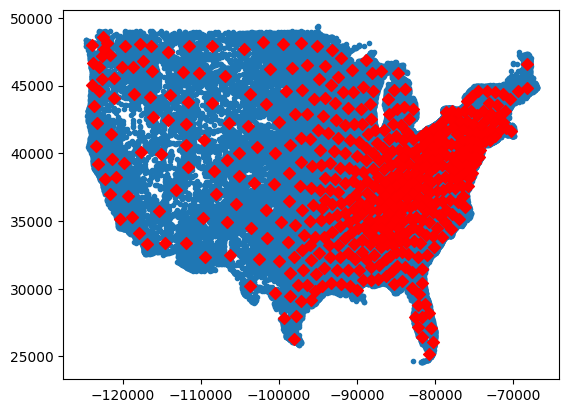

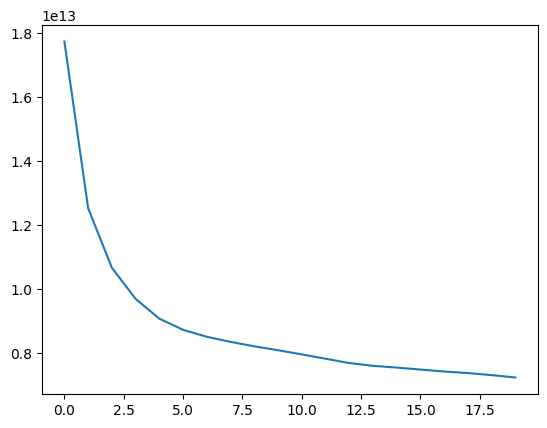

In [5]:
k=500
cities = CITIES[:N,:]
print("clustering:")
np.random.seed() # if you want the random seed to be the same each time, add a parameter like 1
means,assignment,losses = k_means(cities,k,20) # run with loss print statement uncommented to track progress
plt.scatter(cities[:,0],cities[:,1],marker='.')
plt.scatter(means[:,0],means[:,1],c='r',marker='D');
plt.show()
plt.plot(np.array(range(len(losses))), losses)

### Code to save a clustering assignment to a file

In [6]:
with open('clusters.txt', 'a') as fp:
    for i in range(len(CITIES)):
        fp.write(str(assignment[i]))
        fp.write(',')

### Extract a TSP problem from a first region and plot default vs random tour

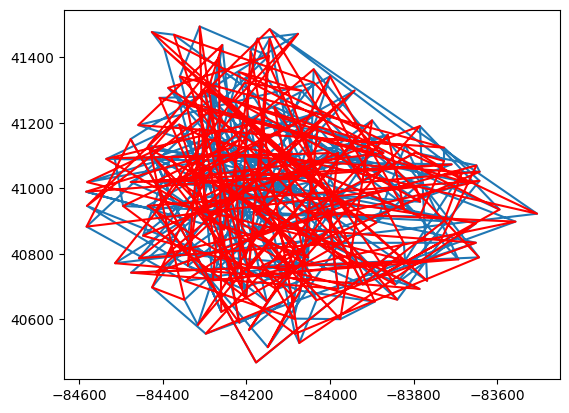

In [7]:
# region 0
r_i = 0
n_r_i = sum(np.where(assignment==r_i,1,0)) # number of cities in region i
region = np.zeros((n_r_i,2))
j = 0 # within-region city number
for i in range(len(CITIES)):
    if assignment[i]==r_i:
        region[j]=CITIES[i]
        j += 1

plt.plot(region[:,0],region[:,1]);
tour = np.array(range(n_r_i))
np.random.shuffle(tour) # random permutation of the city indices within region i
sbt = sorted_by_tour(region,tour)
plt.plot(sbt[:,0],sbt[:,1],'r');

## Section 4: Simulated annealing

In [8]:
# energy1=length of curr, energy2=length of new
def p_accept(curr_len,neighbor_len,temp):
    if neighbor_len<curr_len: return 1 # automatically accept better neighbor
    return math.exp(-(neighbor_len-curr_len)/temp) # accept w.p. decreasing with inferiority of neighbor

# sets a temperature based on the time left [0,1)
def temperature(time_left,scale):
    return time_left*scale+.0000001 

# calculates the sample SD of 100 random tours vs their 1-swap neighbors
def get_ssd(cities):
    n = len(cities)
    perm = np.array(range(n))
    var = 0
    for i in range(100):
        np.random.shuffle(perm[1:n])
        len_orig = tour_length(cities,perm)
        swap(perm,random_pair(n))
        var += (tour_length(cities,perm)-len_orig)**2
    return math.sqrt(var/100)

# run simulated annealing for k_max steps; n_swaps is a now-defuct param that used to control neighborhoods
def anneal(cities,k_max,n_swaps,vals):
    s = get_ssd(cities)
    n = len(cities)
    tour = np.array(range(n))
    np.random.shuffle(tour[1:n])
    for k in range(k_max):
        temp = temperature(1-(k+1)/k_max,s)
        len_curr = tour_length(cities,tour)
        
        # perform and assess a single swap
        p = random_pair(n)
        swap(tour,p)
        len_new = tour_length(cities,tour)
        if np.random.uniform()>=p_accept(len_curr,len_new,temp): #swap back if p_accept is low
            swap(tour,p)

        # record current tour_length
        vals[k] = tour_length(cities,tour)
    return tour




### Experiment with SA parameters
Print/plot outputs for a single region, changing # iterations and # swaps per iteration time-permitting. At $k_{\max}=15000$ with original single-swap neighbors, experiment takes a couple minutes and plot suggests we are not close to the best tour for the single region but significantly better than a random tour.

29480.828336422528
False
5.377584218978882 seconds


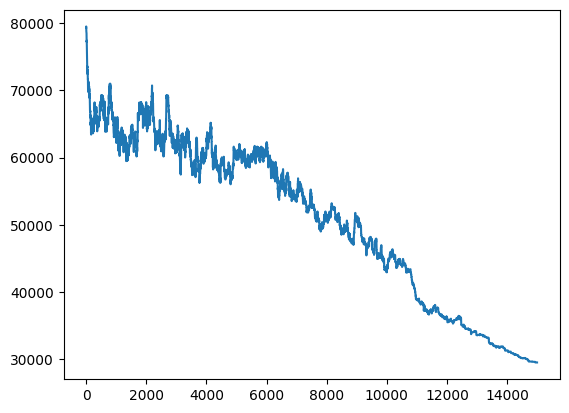

In [9]:
start = time.time()

cities = region # run simulated annealing on a single region (a few hundred cities vs >100k)
k_max = 15000
np.random.seed()
vals = np.zeros(k_max)
sa_tour = anneal(cities,k_max,1,vals) # run simulated annealing for k_max iterations and return tour found
plt.plot(np.array(range(k_max)),vals); # plot how tour length changes across iterations
print(tour_length(cities,sa_tour)) # length of last tour
print(is_local_opt(cities,sa_tour)) # whether last tour is a local optimum

print(time.time()-start,"seconds") # experiment runtime



## Section 4: Simulated annealing

29413.97210417771


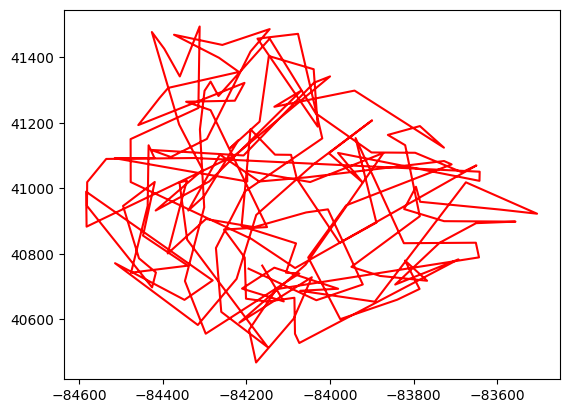

In [10]:
print(tour_length(cities,sa_tour))
sbt = sorted_by_tour(region,sa_tour)
plt.plot(sbt[:,0],sbt[:,1],'r'); # plot the found tour

64882.846135545165


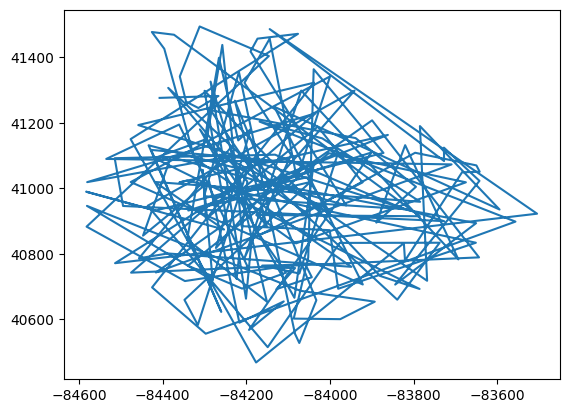

In [11]:
print(tour_length(cities,range(len(cities))))
plt.plot(cities[:,0],cities[:,1]); # plot a random tour for comparison

## Genetic Algorithm

In [12]:
import sys
#Genetic Algorithm

#Generates a random population of size N of tours with size t
def generate_random_population(N, t):
    population = np.empty([N, t], dtype=int)
    tour = np.array(range(t))
    for i in range(0, N): 
        np.random.shuffle(tour)
        population[i] = tour
    return population

#Generates a cloned population of size N given a tour and a mutate chance, where each clone in N clones has a mutate_chance to mutate
def generate_clone_population(N, tour, mutate_chance):
    population = np.empty([N, len(tour)], dtype=int)
    for i in range(0, N):
        clone = tour.copy()
        if np.random.uniform() <= mutate_chance:
            mutate(clone)
        population[i] = clone
    return population

#Crossover breed two tours and return the resulting tour
def crossover_breed (t1, t2):
    t3 = np.zeros((len(t1)), dtype=int)
    for i in range(0, int(len(t1)/2)):
        t3[i] = t1[i]
    j = int(len(t2)/2)
    for i in range(0, len(t2)):
        if t2[i] not in t3:
            t3[j] = t2[i]
            j+=1
    return t3

#Performs a random swap mutate
def mutate (t1):
    swap_pair = random_pair(len(t1)) #determines swap uniformly across cities
    swap(t1, swap_pair)

#Given the cities, a population of tours, and a percent cutoff, determines the top performing tours
def truncate_select (cities, pop, percent): #truncate select best performing tours based on distance of tour
    fitness = []
    for i in range(len(pop)):
        fitness.append(tour_length(cities, pop[i]))
    eval = sorted(fitness)
    N = int(percent * len(pop))
    parents = []
    for i in range(0, N):
        parents.append(pop[fitness.index(eval[i])])
    return parents

def truncate_select_parallel(cities, pop, percent, j):
    with tqdm_joblib(tqdm(desc=str(j) + ": Determining parents", total=len(pop))) as progress_bar:
        fitness = Parallel(n_jobs=-2)(delayed(tour_length_parallel)(cities, pop[i]) for i in range(len(pop)))
    eval = sorted(fitness)
    N = int(percent * len(pop))
    parents = []
    for i in range(0, N):
        parents.append(pop[fitness.index(eval[i])])
    return parents

def check_for_dups(tour):
    if len(tour) == len(set(tour)):
        print("No duplicates exist. Tour is valid")
        return
    print("Duplicates existed in tour. Not valid")
    for i in range(len(tour)):
        for j in range(len(tour)):
            if i != j and tour[i] == tour[j]:
                print("Duplicates exist at indices " + str(i) + " and " + str(j))

def concatenate_tours(tours, CITIES, regions):
    c_i = 0
    final_tour = []
    cluster_number = 0
    for tour in tours:
        for city in tour:
            matches = np.argwhere(CITIES == regions[cluster_number][city])
            for i in range(0, len(matches)):
                for j in range(0, len(matches)):
                    if i != j:
                        if matches[i][0] == matches[j][0]:
                            c_i+=1
                            final_tour.append(matches[i][0])
                            break
                else:
                    continue
                break
        cluster_number+=1
        print("Concatenated " + str(cluster_number) + " clusters")
    check_for_dups(final_tour)
    return final_tour

def matthew_uncross_edges(region, tour):
    flips = 0
    for a in range(len(region)):
        #if a % 10000 == 0: print(str(a) + " done.")
        for b in range(a+1, len(region)):
            na = a+1
            nb = 0 if (b == len(region)-1) else (b+1)
            deltadist = (dist(region[tour[a]], region[tour[b]])+dist(region[tour[na]], region[tour[nb]]) - dist(region[tour[a]], region[tour[na]]) - dist(region[tour[b]], region[tour[nb]]))
            if deltadist < -0.0001:
                while na != b:
                    tour[na], tour[b] = tour[b], tour[na]
                    na += 1
                    if na == b:
                        break
                    b -= 1
                flips +=1
                break
    return flips

In [13]:
def genetic_algorithm(region, prevpop, gens, darwin, mutate_chance_child, mutate_chance_elite, population_size, elite_clone_percent, messiah_margin, messiah_num, print_stats):
    start = time.time()
    #Metric keeping
    avg_fits = []
    best_fits = []
    worst_fits = []
    messiah_lines = []
    super_duper_best_tour = prevpop[0]
    super_duper_best_tour_generation = 0
    super_duper_best_tour_fitness = tour_length(region, super_duper_best_tour)
    
    for i in range(0, gens):
        #print("Generation " + str(i))
        #per generation metrics
        avg = 0
        best = sys.maxsize
        worst = 0
        #creating parent set
        all_parents = truncate_select(region, prevpop, darwin) #retrieves the set of tours to use as set of parents using truncate selection
        elites = all_parents[0:int(elite_clone_percent*len(all_parents))]
        newpop = np.empty([len(prevpop), len(prevpop[0])], dtype=int)
        #creating breeded portion of new population
        for j in range(0, len(prevpop)-int(elite_clone_percent*len(all_parents))): #leaves space for cloning parents
            parents = random_pair(len(all_parents))#selects random pair of parents from set of parents defined earlier
            child = crossover_breed(prevpop[parents[0]], prevpop[parents[1]]) #creates a child to be added to the new population using crossover breeding (ew, incest!)
            if np.random.uniform() <= mutate_chance_child: #only mutates mutate_chance percent of the children added
                mutate(child) #mutates using random swap
            newpop[j] = child
            
            #updates per generation metrics if needed
            child_fitness = tour_length(region, child)
            avg += child_fitness
            if child_fitness < best:
                best = child_fitness
            if child_fitness > worst:
                worst = child_fitness
            if child_fitness < super_duper_best_tour_fitness:
                super_duper_best_tour = child
                # flips=1
                # passes = 0
                # max_passes = 10000
                # #print("Uncrossing Edges: # Initial Tour Length =", tour_length(region, t1))
                # while flips > 0 and passes < max_passes:
                #     flips = matthew_uncross_edges(region, super_duper_best_tour)
                #     passes += 1
                #     #print("# Pass", passes, "(" + str(flips) + " flips)   Tour Length =", tour_length(region, t1))
                super_duper_best_tour_generation = i
                super_duper_best_tour_fitness = tour_length(region, super_duper_best_tour)
        #creating cloned portion of new population
        for j in range(len(prevpop)-int(elite_clone_percent*len(all_parents)), len(prevpop)): #clone parents into the new population
            clone = elites[j-len(prevpop)+int(elite_clone_percent*len(all_parents))]
            if np.random.uniform() <= mutate_chance_elite: #clone has a mutate_chance chance to mutate
                mutate(clone)
            newpop[j] = clone
            #updates per generation metrics if needed
            clone_fitness = tour_length(region, clone)
            avg += clone_fitness
            if clone_fitness < best:
                best = clone_fitness
            if clone_fitness > worst:
                worst = clone_fitness
            if clone_fitness < super_duper_best_tour_fitness:
                super_duper_best_tour = clone
                # flips=1
                # passes = 0
                # max_passes = 10000
                # #print("Uncrossing Edges: # Initial Tour Length =", tour_length(region, t1))
                # while flips > 0 and passes < max_passes:
                #     flips = matthew_uncross_edges(region, super_duper_best_tour)
                #     passes += 1
                #     #print("# Pass", passes, "(" + str(flips) + " flips)   Tour Length =", tour_length(region, t1))
                super_duper_best_tour_generation = i
                super_duper_best_tour_fitness = tour_length(region, super_duper_best_tour)
        #add generation's metrics to plot data
        avg_fits.append(avg/len(prevpop))
        best_fits.append(best)
        worst_fits.append(worst)
        #if conditions for a messiah have been met, reintroduce the messiah into the population
        if best-super_duper_best_tour_fitness >= messiah_margin:
            for k in range(0, messiah_num):
                newpop[k] = super_duper_best_tour #messiah is the best tour the algorithm has encountered so far
            if print_stats: print("Reintroduced " + str(messiah_num) + " messiah(s) in generation " + str(i+1))
            messiah_lines.append(i+1)
        # if i!=0 and abs(best_fits[i] - best_fits[i-1]) < .005: #some stopping condition other than generation
        #     break
        prevpop = newpop

    if(print_stats):
        print(time.time()-start,"seconds")
        for k in range(0, len(messiah_lines)):
            plt.axvline(x=messiah_lines[k], color='purple', linewidth=0.5)
        plt.plot(np.array(range(len(avg_fits))),avg_fits, label="Average per Gen")
        plt.plot(np.array(range(len(best_fits))),best_fits, c='g', label="Best per Gen")
        plt.plot(np.array(range(len(worst_fits))),worst_fits, c='r', label="Worst per Gen")
        plt.scatter(super_duper_best_tour_generation, super_duper_best_tour_fitness, c='y', s=12, marker='o', label="Best Tour")
        plt.xlabel("Generations")
        plt.ylabel("Tour Length")
        plt.legend()
        plt.show()
        
        print("Best Tour Found in generation " + str(super_duper_best_tour_generation) + " with length of " + str(super_duper_best_tour_fitness))

    return super_duper_best_tour

In [19]:
def compute_metrics(population, region, best_tour, best_tour_length, best_tour_generation, gen):
    avg=0
    best=0
    worst = sys.maxsize
    with tqdm_joblib(tqdm(desc=str(gen)+": Computing metrics", total=len(population))) as progress_bar:
        fitness = Parallel(n_jobs=-2)(delayed(tour_length_parallel)(region, child) for child in population)
    i=0
    for fit in fitness:
        avg += fit
        if best > fit:
            best = fit
        if worst < fit:
            worst = fit
        if best_tour_length > fit:
            best_tour_length = fit
            best_tour = population[i]
            best_tour_generation = i
        i+=1
    return avg/len(population), best, worst

def get_best(population, region):
    best = 0
    fitness = Parallel(n_jobs=-2)(delayed(tour_length_parallel)(region, child) for child in population)
    for fit in fitness:
        if best > fit:
            best = fit
    return best

def get_worst(population, region):
    worst = sys.maxsize
    fitness = Parallel(n_jobs=-2)(delayed(tour_length_parallel)(region, child) for child in population)
    for child in population:
        fitness = tour_length_parallel(region, child)
        if worst < fitness:
            worst = fitness
    return worst

def update_best(population, region, best_tour, best_tour_length, best_tour_generation):
    i = 0
    for child in population:
        fitness = tour_length_parallel(region, child)
        if best_tour_length > fitness:
            best_tour_length = fitness
            best_tour = child
            best_tour_generation = i
        i+=1

def breed(prevpop, all_parents, mutate_chance_child):
    parents = random_pair(len(all_parents))#selects random pair of parents from set of parents defined earlier
    child = crossover_breed(prevpop[parents[0]], prevpop[parents[1]]) #creates a child to be added to the new population using crossover breeding (ew, incest!)
    if np.random.uniform() <= mutate_chance_child: #only mutates mutate_chance percent of the children added
        mutate(child) #mutates using random swap
    return child

def clone(prevpop, elites, j, elite_clone_percent, all_parents, mutate_chance_elite):
    clone = elites[j-len(prevpop)+int(elite_clone_percent*len(all_parents))]
    if np.random.uniform() <= mutate_chance_elite: #clone has a mutate_chance chance to mutate
        mutate(clone)
    return clone

def genetic_algorithm_parallel(region, prevpop, gens, darwin, mutate_chance_child, mutate_chance_elite, population_size, elite_clone_percent, messiah_margin, messiah_num, print_stats):
    start = time.time()
    #Metric keeping
    avg_fits = []
    best_fits = []
    worst_fits = []
    messiah_lines = []
    super_duper_best_tour = prevpop[0]
    super_duper_best_tour_generation = 0
    super_duper_best_tour_fitness = tour_length(region, super_duper_best_tour)
    
    for i in range(0, gens):
        #print("Generation " + str(i))
        #per generation metrics
        # avg = 0
        # best = sys.maxsize
        # worst = 0
        #creating parent set
        all_parents = truncate_select_parallel(region, prevpop, darwin, i) #retrieves the set of tours to use as set of parents using truncate selection
        elites = all_parents[0:int(elite_clone_percent*len(all_parents))]
        #newpop = np.empty([len(prevpop), len(prevpop[0])], dtype=int)
        #creating new population
        with tqdm_joblib(tqdm(desc=str(i)+": Generating population", total=len(prevpop))) as progress_bar:
            newpop = Parallel(n_jobs=-2)(delayed(breed)(prevpop, all_parents, mutate_chance_child) for j in range(0, len(prevpop)-int(elite_clone_percent*len(all_parents)))) + Parallel(n_jobs=-2)(delayed(clone)(prevpop, elites, j, elite_clone_percent, all_parents, mutate_chance_elite) for j in range(len(prevpop)-int(elite_clone_percent*len(all_parents)), len(prevpop)))
        #add generation's metrics to plot data
        metrics = compute_metrics(newpop, region, super_duper_best_tour, super_duper_best_tour_fitness, super_duper_best_tour_generation, i)
        avg_fits.append(metrics[0])
        best_fits.append(metrics[1])
        worst_fits.append(metrics[2])
        #if conditions for a messiah have been met, reintroduce the messiah into the population
        if best_fits[-1]-super_duper_best_tour_fitness >= messiah_margin:
            for k in range(0, messiah_num):
                newpop[k] = super_duper_best_tour #messiah is the best tour the algorithm has encountered so far
            if print_stats: print("Reintroduced " + str(messiah_num) + " messiah(s) in generation " + str(i+1))
            messiah_lines.append(i+1)
        # if i!=0 and abs(best_fits[i] - best_fits[i-1]) < .005: #some stopping condition other than generation
        #     break
        prevpop = newpop

    if(print_stats):
        print(time.time()-start,"seconds")
        for k in range(0, len(messiah_lines)):
            plt.axvline(x=messiah_lines[k], color='purple', linewidth=0.5)
        plt.plot(np.array(range(len(avg_fits))),avg_fits, label="Average per Gen")
        plt.plot(np.array(range(len(best_fits))),best_fits, c='g', label="Best per Gen")
        plt.plot(np.array(range(len(worst_fits))),worst_fits, c='r', label="Worst per Gen")
        plt.scatter(super_duper_best_tour_generation, super_duper_best_tour_fitness, c='y', s=12, marker='o', label="Best Tour")
        plt.xlabel("Generations")
        plt.ylabel("Tour Length")
        plt.legend()
        plt.show()
        
        print("Best Tour Found in generation " + str(super_duper_best_tour_generation) + " with length of " + str(super_duper_best_tour_fitness))

    return super_duper_best_tour

In [26]:
#parameters for running on whole data set
gens = 25
darwin = .50 
mutate_chance_child = .35 
mutate_chance_elite = .75
population_size = 50
elite_clone_percent = .35/darwin
messiah_margin = 100 
messiah_percent = .50
messiah_num = int(messiah_percent * population_size)

start = time.time()
prevpop = generate_random_population(population_size, len(CITIES)) #generates a random population
t = genetic_algorithm(CITIES, prevpop, gens, darwin, mutate_chance_child, mutate_chance_elite, population_size, elite_clone_percent, messiah_margin, messiah_num, True)
print(time.time()-start, "seconds")

KeyboardInterrupt: 

In [15]:
#building regions
start = time.time()
regions = []
max = 0
max_i = 0
for r_i in range(0, k): #k is the number of clusters(regions) from k-means
    n_r_i = sum(np.where(assignment==r_i,1,0)) #number of cities in region r_i
    if n_r_i > max:
        max=n_r_i
        max_i=r_i
    region_i = np.zeros((n_r_i, 2))
    j = 0
    for i in range(len(CITIES)):
        if assignment[i]==r_i:
            region_i[j] = CITIES[i]
            j += 1
    regions.append(region_i)
    print("Region " + str(r_i) + " completed")
print("Completed region building")
print(time.time()-start, "seconds")
print(max)
print(max_i)

Region 0 completed
Region 1 completed
Region 2 completed
Region 3 completed
Region 4 completed
Region 5 completed
Region 6 completed
Region 7 completed
Region 8 completed
Region 9 completed
Region 10 completed
Region 11 completed
Region 12 completed
Region 13 completed
Region 14 completed
Region 15 completed
Region 16 completed
Region 17 completed
Region 18 completed
Region 19 completed
Region 20 completed
Region 21 completed
Region 22 completed
Region 23 completed
Region 24 completed
Region 25 completed
Region 26 completed
Region 27 completed
Region 28 completed
Region 29 completed
Region 30 completed
Region 31 completed
Region 32 completed
Region 33 completed
Region 34 completed
Region 35 completed
Region 36 completed
Region 37 completed
Region 38 completed
Region 39 completed
Region 40 completed
Region 41 completed
Region 42 completed
Region 43 completed
Region 44 completed
Region 45 completed
Region 46 completed
Region 47 completed
Region 48 completed
Region 49 completed
Region 50 

Running genetic algorithm on cluster 424 with 722 cities
Reintroduced 25 messiah(s) in generation 5
Reintroduced 25 messiah(s) in generation 11
Reintroduced 25 messiah(s) in generation 20
Reintroduced 25 messiah(s) in generation 24
2.1639418601989746 seconds


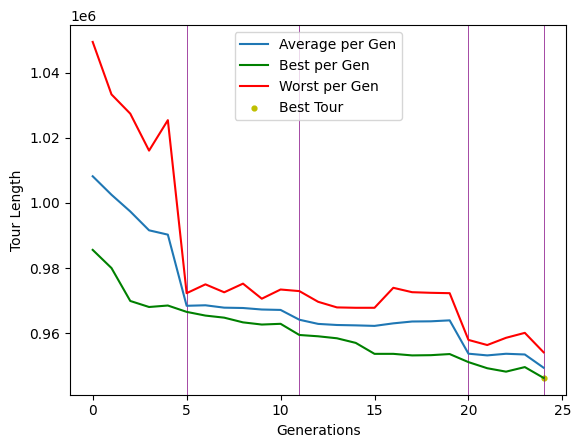

Best Tour Found in generation 24 with length of 946226.3033335167
Completed sub-tour for cluster number 424 ---------------------------------------------------------------------


In [17]:
gens = 25
darwin = .50 
mutate_chance_child = .35 
mutate_chance_elite = .75
population_size = 50
elite_clone_percent = .35/darwin
messiah_margin = 100 
messiah_percent = .50
messiah_num = int(messiah_percent * population_size)
reg = regions[max_i]
n_r_i = len(reg)
prevpop = generate_random_population(population_size, n_r_i) #generates a random population
print("Running genetic algorithm on cluster " + str(max_i) + " with " + str(n_r_i) + " cities")
t = genetic_algorithm(reg, prevpop, gens, darwin, mutate_chance_child, mutate_chance_elite, population_size, elite_clone_percent, messiah_margin, messiah_num, True)
print("Completed sub-tour for cluster number " + str(max_i) + " ---------------------------------------------------------------------")

In [28]:
#parameters for running on all clusters
gens = 100
darwin = .50 
mutate_chance_child = .35 
mutate_chance_elite = .75
population_size = 100 
elite_clone_percent = .35/darwin
messiah_margin = 100 
messiah_percent = .50
messiah_num = int(messiah_percent * population_size)

tours = []
t_i = 0
start_time = time.time()
# for reg in regions:
#     n_r_i = len(reg)
#     prevpop = generate_random_population(population_size, n_r_i) #generates a random population
#     print("Running genetic algorithm on cluster " + str(t_i) + " with " + str(n_r_i) + " cities")
#     t = genetic_algorithm(reg, prevpop, gens, darwin, mutate_chance_child, mutate_chance_elite, population_size, elite_clone_percent, messiah_margin, messiah_num, True)
#     tours.append(t)
#     print("Completed sub-tour for cluster number " + str(t_i) + " ---------------------------------------------------------------------")
#     t_i+=1
with tqdm_joblib(tqdm(desc=str(i)+": Running Genetic on All Clusters", total=len(regions))) as progress_bar:
            tours = Parallel(n_jobs=-2)(delayed(genetic_algorithm)(reg, generate_random_population(population_size, len(reg)), gens, darwin, mutate_chance_child, mutate_chance_elite, population_size, elite_clone_percent, messiah_margin, messiah_num, True) for reg in regions)
print(time.time()-start, "seconds")

115474: Running Genetic on All Clusters:  23%|▏| 116/500 [02:39<08:55,  1.39s/it

Reintroduced 50 messiah(s) in generation 5
Reintroduced 50 messiah(s) in generation 11
Reintroduced 50 messiah(s) in generation 18
Reintroduced 50 messiah(s) in generation 23
Reintroduced 50 messiah(s) in generation 28
Reintroduced 50 messiah(s) in generation 34
Reintroduced 50 messiah(s) in generation 39
Reintroduced 50 messiah(s) in generation 43
Reintroduced 50 messiah(s) in generation 47
Reintroduced 50 messiah(s) in generation 53
Reintroduced 50 messiah(s) in generation 59
Reintroduced 50 messiah(s) in generation 68
Reintroduced 50 messiah(s) in generation 73
Reintroduced 50 messiah(s) in generation 82
Reintroduced 50 messiah(s) in generation 90
Reintroduced 50 messiah(s) in generation 94
Reintroduced 50 messiah(s) in generation 99
8.997581243515015 seconds
Figure(640x480)
Best Tour Found in generation 99 with length of 128632.87013073785
Reintroduced 50 messiah(s) in generation 9
Reintroduced 50 messiah(s) in generation 21
Reintroduced 50 messiah(s) in generation 25
Reintroduced 

115474: Running Genetic on All Clusters:  24%|▏| 119/500 [02:44<09:32,  1.50s/it

Reintroduced 50 messiah(s) in generation 2
Reintroduced 50 messiah(s) in generation 7
Reintroduced 50 messiah(s) in generation 10
Reintroduced 50 messiah(s) in generation 17
Reintroduced 50 messiah(s) in generation 20
Reintroduced 50 messiah(s) in generation 26
Reintroduced 50 messiah(s) in generation 32
Reintroduced 50 messiah(s) in generation 34
Reintroduced 50 messiah(s) in generation 38
Reintroduced 50 messiah(s) in generation 47
Reintroduced 50 messiah(s) in generation 50
Reintroduced 50 messiah(s) in generation 54
Reintroduced 50 messiah(s) in generation 58
Reintroduced 50 messiah(s) in generation 61
Reintroduced 50 messiah(s) in generation 68
Reintroduced 50 messiah(s) in generation 71
Reintroduced 50 messiah(s) in generation 73
Reintroduced 50 messiah(s) in generation 80
Reintroduced 50 messiah(s) in generation 84
Reintroduced 50 messiah(s) in generation 87
Reintroduced 50 messiah(s) in generation 90
Reintroduced 50 messiah(s) in generation 93
Reintroduced 50 messiah(s) in gene

115474: Running Genetic on All Clusters:  25%|▎| 126/500 [02:52<07:34,  1.22s/it

Reintroduced 50 messiah(s) in generation 2
Reintroduced 50 messiah(s) in generation 10
Reintroduced 50 messiah(s) in generation 17
Reintroduced 50 messiah(s) in generation 22
Reintroduced 50 messiah(s) in generation 28
Reintroduced 50 messiah(s) in generation 32
Reintroduced 50 messiah(s) in generation 42
Reintroduced 50 messiah(s) in generation 47
Reintroduced 50 messiah(s) in generation 50
Reintroduced 50 messiah(s) in generation 52
Reintroduced 50 messiah(s) in generation 55
Reintroduced 50 messiah(s) in generation 60
Reintroduced 50 messiah(s) in generation 66
Reintroduced 50 messiah(s) in generation 68
Reintroduced 50 messiah(s) in generation 70
Reintroduced 50 messiah(s) in generation 75
Reintroduced 50 messiah(s) in generation 78
Reintroduced 50 messiah(s) in generation 85
Reintroduced 50 messiah(s) in generation 86
Reintroduced 50 messiah(s) in generation 87
Reintroduced 50 messiah(s) in generation 88
Reintroduced 50 messiah(s) in generation 90
Reintroduced 50 messiah(s) in gen

115474: Running Genetic on All Clusters:  26%|▎| 129/500 [02:56<08:31,  1.38s/it

Reintroduced 50 messiah(s) in generation 2
Reintroduced 50 messiah(s) in generation 7
Reintroduced 50 messiah(s) in generation 13
Reintroduced 50 messiah(s) in generation 16
Reintroduced 50 messiah(s) in generation 19
Reintroduced 50 messiah(s) in generation 23
Reintroduced 50 messiah(s) in generation 25
Reintroduced 50 messiah(s) in generation 29
Reintroduced 50 messiah(s) in generation 35
Reintroduced 50 messiah(s) in generation 41
Reintroduced 50 messiah(s) in generation 49
Reintroduced 50 messiah(s) in generation 51
Reintroduced 50 messiah(s) in generation 52
Reintroduced 50 messiah(s) in generation 53
Reintroduced 50 messiah(s) in generation 54
Reintroduced 50 messiah(s) in generation 55
Reintroduced 50 messiah(s) in generation 56
Reintroduced 50 messiah(s) in generation 57
Reintroduced 50 messiah(s) in generation 58
Reintroduced 50 messiah(s) in generation 59
Reintroduced 50 messiah(s) in generation 60
Reintroduced 50 messiah(s) in generation 61
Reintroduced 50 messiah(s) in gene

115474: Running Genetic on All Clusters:  26%|▎| 132/500 [03:00<08:56,  1.46s/it

Reintroduced 50 messiah(s) in generation 2
Reintroduced 50 messiah(s) in generation 13
Reintroduced 50 messiah(s) in generation 18
Reintroduced 50 messiah(s) in generation 24
Reintroduced 50 messiah(s) in generation 40
Reintroduced 50 messiah(s) in generation 43
Reintroduced 50 messiah(s) in generation 45
Reintroduced 50 messiah(s) in generation 52
Reintroduced 50 messiah(s) in generation 56
Reintroduced 50 messiah(s) in generation 59
Reintroduced 50 messiah(s) in generation 63
Reintroduced 50 messiah(s) in generation 65
Reintroduced 50 messiah(s) in generation 72
Reintroduced 50 messiah(s) in generation 76
Reintroduced 50 messiah(s) in generation 78
Reintroduced 50 messiah(s) in generation 81
Reintroduced 50 messiah(s) in generation 84
Reintroduced 50 messiah(s) in generation 88
Reintroduced 50 messiah(s) in generation 92
Reintroduced 50 messiah(s) in generation 95
8.43635368347168 seconds
Figure(640x480)
Best Tour Found in generation 98 with length of 99878.59257944098
Reintroduced 5

115474: Running Genetic on All Clusters:  29%|▎| 147/500 [03:23<07:45,  1.32s/it

Reintroduced 50 messiah(s) in generation 2
Reintroduced 50 messiah(s) in generation 12
Reintroduced 50 messiah(s) in generation 16
Reintroduced 50 messiah(s) in generation 23
Reintroduced 50 messiah(s) in generation 29
Reintroduced 50 messiah(s) in generation 40
Reintroduced 50 messiah(s) in generation 45
Reintroduced 50 messiah(s) in generation 48
Reintroduced 50 messiah(s) in generation 53
Reintroduced 50 messiah(s) in generation 62
Reintroduced 50 messiah(s) in generation 66
Reintroduced 50 messiah(s) in generation 80
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 88
Reintroduced 50 messiah(s) in generation 91
Reintroduced 50 messiah(s) in generation 95
Reintroduced 50 messiah(s) in generation 100
8.935413599014282 seconds
Figure(640x480)
Best Tour Found in generation 98 with length of 98434.98367667898
Reintroduced 50 messiah(s) in generation 6
Reintroduced 50 messiah(s) in generation 10
Reintroduced 50 messiah(s) in generation 13
Reintroduced 

115474: Running Genetic on All Clusters:  30%|▎| 148/500 [03:25<09:47,  1.67s/it

Reintroduced 50 messiah(s) in generation 4
Reintroduced 50 messiah(s) in generation 8
Reintroduced 50 messiah(s) in generation 16
Reintroduced 50 messiah(s) in generation 22
Reintroduced 50 messiah(s) in generation 27
Reintroduced 50 messiah(s) in generation 31
Reintroduced 50 messiah(s) in generation 36
Reintroduced 50 messiah(s) in generation 40
Reintroduced 50 messiah(s) in generation 41
Reintroduced 50 messiah(s) in generation 42
Reintroduced 50 messiah(s) in generation 43
Reintroduced 50 messiah(s) in generation 44
Reintroduced 50 messiah(s) in generation 45
Reintroduced 50 messiah(s) in generation 46
Reintroduced 50 messiah(s) in generation 47
Reintroduced 50 messiah(s) in generation 48
Reintroduced 50 messiah(s) in generation 49
Reintroduced 50 messiah(s) in generation 50
Reintroduced 50 messiah(s) in generation 51
Reintroduced 50 messiah(s) in generation 52
Reintroduced 50 messiah(s) in generation 53
Reintroduced 50 messiah(s) in generation 54
Reintroduced 50 messiah(s) in gene

115474: Running Genetic on All Clusters:  39%|▍| 196/500 [04:49<08:47,  1.73s/it

Reintroduced 50 messiah(s) in generation 2
Reintroduced 50 messiah(s) in generation 4
Reintroduced 50 messiah(s) in generation 7
Reintroduced 50 messiah(s) in generation 17
Reintroduced 50 messiah(s) in generation 30
Reintroduced 50 messiah(s) in generation 37
Reintroduced 50 messiah(s) in generation 39
Reintroduced 50 messiah(s) in generation 41
Reintroduced 50 messiah(s) in generation 45
Reintroduced 50 messiah(s) in generation 52
Reintroduced 50 messiah(s) in generation 56
Reintroduced 50 messiah(s) in generation 58
Reintroduced 50 messiah(s) in generation 60
Reintroduced 50 messiah(s) in generation 68
Reintroduced 50 messiah(s) in generation 79
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 89
Reintroduced 50 messiah(s) in generation 93
Reintroduced 50 messiah(s) in generation 95
Reintroduced 50 messiah(s) in generation 97
Reintroduced 50 messiah(s) in generation 99
Reintroduced 50 messiah(s) in generation 100
8.635189056396484 seconds
Figure(6

115474: Running Genetic on All Clusters:  42%|▍| 209/500 [05:11<08:33,  1.76s/it

Reintroduced 50 messiah(s) in generation 12
Reintroduced 50 messiah(s) in generation 19
Reintroduced 50 messiah(s) in generation 30
Reintroduced 50 messiah(s) in generation 34
Reintroduced 50 messiah(s) in generation 41
Reintroduced 50 messiah(s) in generation 45
Reintroduced 50 messiah(s) in generation 49
Reintroduced 50 messiah(s) in generation 53
Reintroduced 50 messiah(s) in generation 55
Reintroduced 50 messiah(s) in generation 61
Reintroduced 50 messiah(s) in generation 65
Reintroduced 50 messiah(s) in generation 71
Reintroduced 50 messiah(s) in generation 75
Reintroduced 50 messiah(s) in generation 77
Reintroduced 50 messiah(s) in generation 81
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 88
Reintroduced 50 messiah(s) in generation 91
Reintroduced 50 messiah(s) in generation 95
Reintroduced 50 messiah(s) in generation 98
7.942429065704346 seconds
Figure(640x480)
Best Tour Found in generation 99 with length of 104594.14455719631
Reintroduce

115474: Running Genetic on All Clusters:  44%|▍| 220/500 [05:34<06:13,  1.33s/it

Reintroduced 50 messiah(s) in generation 79
Reintroduced 50 messiah(s) in generation 86
Reintroduced 50 messiah(s) in generation 92
Reintroduced 50 messiah(s) in generation 98
Reintroduced 50 messiah(s) in generation 99
Reintroduced 50 messiah(s) in generation 100
8.760513067245483 seconds
Figure(640x480)
Best Tour Found in generation 96 with length of 44128.21426201275
Reintroduced 50 messiah(s) in generation 3
Reintroduced 50 messiah(s) in generation 8
Reintroduced 50 messiah(s) in generation 11
Reintroduced 50 messiah(s) in generation 15
Reintroduced 50 messiah(s) in generation 21
Reintroduced 50 messiah(s) in generation 29
Reintroduced 50 messiah(s) in generation 35
Reintroduced 50 messiah(s) in generation 43
Reintroduced 50 messiah(s) in generation 49
Reintroduced 50 messiah(s) in generation 61
Reintroduced 50 messiah(s) in generation 68
Reintroduced 50 messiah(s) in generation 75
Reintroduced 50 messiah(s) in generation 80
Reintroduced 50 messiah(s) in generation 87
Reintroduced 

115474: Running Genetic on All Clusters:  47%|▍| 233/500 [06:00<09:18,  2.09s/it

Best Tour Found in generation 85 with length of 79748.32243999495
Reintroduced 50 messiah(s) in generation 2
Reintroduced 50 messiah(s) in generation 9
Reintroduced 50 messiah(s) in generation 17
Reintroduced 50 messiah(s) in generation 24
Reintroduced 50 messiah(s) in generation 28
Reintroduced 50 messiah(s) in generation 32
Reintroduced 50 messiah(s) in generation 48
Reintroduced 50 messiah(s) in generation 55
Reintroduced 50 messiah(s) in generation 61
Reintroduced 50 messiah(s) in generation 63
Reintroduced 50 messiah(s) in generation 69
Reintroduced 50 messiah(s) in generation 73
Reintroduced 50 messiah(s) in generation 77
Reintroduced 50 messiah(s) in generation 86
Reintroduced 50 messiah(s) in generation 92
Reintroduced 50 messiah(s) in generation 100
11.49183201789856 seconds
Figure(640x480)
Best Tour Found in generation 97 with length of 131179.28229944166
Reintroduced 50 messiah(s) in generation 5
Reintroduced 50 messiah(s) in generation 9
Reintroduced 50 messiah(s) in genera

115474: Running Genetic on All Clusters:  48%|▍| 241/500 [06:16<08:54,  2.06s/it

Reintroduced 50 messiah(s) in generation 25
Reintroduced 50 messiah(s) in generation 30
Reintroduced 50 messiah(s) in generation 39
Reintroduced 50 messiah(s) in generation 45
Reintroduced 50 messiah(s) in generation 49
Reintroduced 50 messiah(s) in generation 54
Reintroduced 50 messiah(s) in generation 58
Reintroduced 50 messiah(s) in generation 63
Reintroduced 50 messiah(s) in generation 76
Reintroduced 50 messiah(s) in generation 81
Reintroduced 50 messiah(s) in generation 89
Reintroduced 50 messiah(s) in generation 91
Reintroduced 50 messiah(s) in generation 95
10.542346715927124 seconds
Figure(640x480)
Best Tour Found in generation 99 with length of 72410.48314825555
Reintroduced 50 messiah(s) in generation 2
Reintroduced 50 messiah(s) in generation 14
Reintroduced 50 messiah(s) in generation 28
Reintroduced 50 messiah(s) in generation 31
Reintroduced 50 messiah(s) in generation 40
Reintroduced 50 messiah(s) in generation 47
Reintroduced 50 messiah(s) in generation 55
Reintroduced

115474: Running Genetic on All Clusters:  49%|▍| 245/500 [06:20<05:44,  1.35s/it

Reintroduced 50 messiah(s) in generation 96
6.6876280307769775 seconds
Figure(640x480)
Best Tour Found in generation 97 with length of 52083.75622460478
Reintroduced 50 messiah(s) in generation 6
Reintroduced 50 messiah(s) in generation 16
Reintroduced 50 messiah(s) in generation 25
Reintroduced 50 messiah(s) in generation 34
Reintroduced 50 messiah(s) in generation 37
Reintroduced 50 messiah(s) in generation 48
Reintroduced 50 messiah(s) in generation 51
Reintroduced 50 messiah(s) in generation 55
Reintroduced 50 messiah(s) in generation 58
Reintroduced 50 messiah(s) in generation 62
Reintroduced 50 messiah(s) in generation 64
Reintroduced 50 messiah(s) in generation 70
Reintroduced 50 messiah(s) in generation 76
Reintroduced 50 messiah(s) in generation 81
Reintroduced 50 messiah(s) in generation 89
Reintroduced 50 messiah(s) in generation 91
Reintroduced 50 messiah(s) in generation 94
Reintroduced 50 messiah(s) in generation 98
10.396342754364014 seconds
Figure(640x480)
Best Tour Fou

115474: Running Genetic on All Clusters:  54%|▌| 268/500 [07:02<09:14,  2.39s/it

Reintroduced 50 messiah(s) in generation 64
Reintroduced 50 messiah(s) in generation 65
Reintroduced 50 messiah(s) in generation 66
Reintroduced 50 messiah(s) in generation 67
Reintroduced 50 messiah(s) in generation 68
Reintroduced 50 messiah(s) in generation 69
Reintroduced 50 messiah(s) in generation 70
Reintroduced 50 messiah(s) in generation 71
Reintroduced 50 messiah(s) in generation 72
Reintroduced 50 messiah(s) in generation 73
Reintroduced 50 messiah(s) in generation 74
Reintroduced 50 messiah(s) in generation 75
Reintroduced 50 messiah(s) in generation 76
Reintroduced 50 messiah(s) in generation 77
Reintroduced 50 messiah(s) in generation 78
Reintroduced 50 messiah(s) in generation 79
Reintroduced 50 messiah(s) in generation 80
Reintroduced 50 messiah(s) in generation 81
Reintroduced 50 messiah(s) in generation 82
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 84
Reintroduced 50 messiah(s) in generation 85
Reintroduced 50 messiah(s) in ge

115474: Running Genetic on All Clusters:  55%|▌| 273/500 [07:04<03:30,  1.08it/s

Reintroduced 50 messiah(s) in generation 84
Reintroduced 50 messiah(s) in generation 85
Reintroduced 50 messiah(s) in generation 86
Reintroduced 50 messiah(s) in generation 87
Reintroduced 50 messiah(s) in generation 88
Reintroduced 50 messiah(s) in generation 89
Reintroduced 50 messiah(s) in generation 90
Reintroduced 50 messiah(s) in generation 91
Reintroduced 50 messiah(s) in generation 92
Reintroduced 50 messiah(s) in generation 93
Reintroduced 50 messiah(s) in generation 94
Reintroduced 50 messiah(s) in generation 95
Reintroduced 50 messiah(s) in generation 96
Reintroduced 50 messiah(s) in generation 97
Reintroduced 50 messiah(s) in generation 98
Reintroduced 50 messiah(s) in generation 99
Reintroduced 50 messiah(s) in generation 100
8.367475748062134 seconds
Figure(640x480)
Best Tour Found in generation 46 with length of 46484.77568246951
Reintroduced 50 messiah(s) in generation 3
Reintroduced 50 messiah(s) in generation 12
Reintroduced 50 messiah(s) in generation 18
Reintroduced

115474: Running Genetic on All Clusters:  57%|▌| 286/500 [07:22<02:58,  1.20it/s

Reintroduced 50 messiah(s) in generation 67
Reintroduced 50 messiah(s) in generation 70
Reintroduced 50 messiah(s) in generation 79
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 86
Reintroduced 50 messiah(s) in generation 92
Reintroduced 50 messiah(s) in generation 96
Reintroduced 50 messiah(s) in generation 99
16.473119974136353 seconds
Figure(640x480)
Best Tour Found in generation 99 with length of 145544.9997798854
Reintroduced 50 messiah(s) in generation 3
Reintroduced 50 messiah(s) in generation 10
Reintroduced 50 messiah(s) in generation 16
Reintroduced 50 messiah(s) in generation 21
Reintroduced 50 messiah(s) in generation 27
Reintroduced 50 messiah(s) in generation 34
Reintroduced 50 messiah(s) in generation 40
Reintroduced 50 messiah(s) in generation 44
Reintroduced 50 messiah(s) in generation 54
Reintroduced 50 messiah(s) in generation 59
Reintroduced 50 messiah(s) in generation 62
Reintroduced 50 messiah(s) in generation 70
Reintroduced

115474: Running Genetic on All Clusters:  62%|▌| 308/500 [07:59<04:13,  1.32s/it


Reintroduced 50 messiah(s) in generation 77
Reintroduced 50 messiah(s) in generation 86
Reintroduced 50 messiah(s) in generation 90
Reintroduced 50 messiah(s) in generation 91
Reintroduced 50 messiah(s) in generation 93
Reintroduced 50 messiah(s) in generation 96
12.757690668106079 seconds
Figure(640x480)
Best Tour Found in generation 99 with length of 84322.30550571463
Reintroduced 50 messiah(s) in generation 3
Reintroduced 50 messiah(s) in generation 7
Reintroduced 50 messiah(s) in generation 9
Reintroduced 50 messiah(s) in generation 13
Reintroduced 50 messiah(s) in generation 20
Reintroduced 50 messiah(s) in generation 22
Reintroduced 50 messiah(s) in generation 26
Reintroduced 50 messiah(s) in generation 28
Reintroduced 50 messiah(s) in generation 32
Reintroduced 50 messiah(s) in generation 34
Reintroduced 50 messiah(s) in generation 35
Reintroduced 50 messiah(s) in generation 36
Reintroduced 50 messiah(s) in generation 37
Reintroduced 50 messiah(s) in generation 38
Reintroduced 

115474: Running Genetic on All Clusters:  65%|▋| 324/500 [08:28<04:51,  1.66s/it

Reintroduced 50 messiah(s) in generation 78
Reintroduced 50 messiah(s) in generation 87
Reintroduced 50 messiah(s) in generation 90
Reintroduced 50 messiah(s) in generation 96
Reintroduced 50 messiah(s) in generation 99
7.639614105224609 seconds
Figure(640x480)
Best Tour Found in generation 99 with length of 46673.532367773165
Reintroduced 50 messiah(s) in generation 2
Reintroduced 50 messiah(s) in generation 8
Reintroduced 50 messiah(s) in generation 10
Reintroduced 50 messiah(s) in generation 13
Reintroduced 50 messiah(s) in generation 17
Reintroduced 50 messiah(s) in generation 18
Reintroduced 50 messiah(s) in generation 29
Reintroduced 50 messiah(s) in generation 32
Reintroduced 50 messiah(s) in generation 33
Reintroduced 50 messiah(s) in generation 37
Reintroduced 50 messiah(s) in generation 41
Reintroduced 50 messiah(s) in generation 46
Reintroduced 50 messiah(s) in generation 48
Reintroduced 50 messiah(s) in generation 56
Reintroduced 50 messiah(s) in generation 59
Reintroduced 

115474: Running Genetic on All Clusters:  65%|▋| 327/500 [08:34<04:16,  1.48s/it


Reintroduced 50 messiah(s) in generation 63
Reintroduced 50 messiah(s) in generation 69
Reintroduced 50 messiah(s) in generation 78
Reintroduced 50 messiah(s) in generation 82
Reintroduced 50 messiah(s) in generation 87
Reintroduced 50 messiah(s) in generation 89
Reintroduced 50 messiah(s) in generation 90
Reintroduced 50 messiah(s) in generation 92
13.349849939346313 seconds
Figure(640x480)
Best Tour Found in generation 99 with length of 66561.30382324131
Reintroduced 50 messiah(s) in generation 4
Reintroduced 50 messiah(s) in generation 30
Reintroduced 50 messiah(s) in generation 38
Reintroduced 50 messiah(s) in generation 44
Reintroduced 50 messiah(s) in generation 46
Reintroduced 50 messiah(s) in generation 53
Reintroduced 50 messiah(s) in generation 56
Reintroduced 50 messiah(s) in generation 58
Reintroduced 50 messiah(s) in generation 66
Reintroduced 50 messiah(s) in generation 68
Reintroduced 50 messiah(s) in generation 73
Reintroduced 50 messiah(s) in generation 78
Reintroduce

115474: Running Genetic on All Clusters:  68%|▋| 340/500 [08:59<06:35,  2.47s/it

Reintroduced 50 messiah(s) in generation 18
Reintroduced 50 messiah(s) in generation 20
Reintroduced 50 messiah(s) in generation 27
Reintroduced 50 messiah(s) in generation 30
Reintroduced 50 messiah(s) in generation 37
Reintroduced 50 messiah(s) in generation 39
Reintroduced 50 messiah(s) in generation 40
Reintroduced 50 messiah(s) in generation 42
Reintroduced 50 messiah(s) in generation 43
Reintroduced 50 messiah(s) in generation 44
Reintroduced 50 messiah(s) in generation 49
Reintroduced 50 messiah(s) in generation 50
Reintroduced 50 messiah(s) in generation 51
Reintroduced 50 messiah(s) in generation 52
Reintroduced 50 messiah(s) in generation 53
Reintroduced 50 messiah(s) in generation 54
Reintroduced 50 messiah(s) in generation 55
Reintroduced 50 messiah(s) in generation 56
Reintroduced 50 messiah(s) in generation 57
Reintroduced 50 messiah(s) in generation 58
Reintroduced 50 messiah(s) in generation 59
Reintroduced 50 messiah(s) in generation 60
Reintroduced 50 messiah(s) in ge

115474: Running Genetic on All Clusters:  70%|▋| 352/500 [09:12<02:07,  1.16it/s

Reintroduced 50 messiah(s) in generation 44
Reintroduced 50 messiah(s) in generation 52
Reintroduced 50 messiah(s) in generation 55
Reintroduced 50 messiah(s) in generation 58
Reintroduced 50 messiah(s) in generation 66
Reintroduced 50 messiah(s) in generation 75
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 87
Reintroduced 50 messiah(s) in generation 92
Reintroduced 50 messiah(s) in generation 98
11.392090082168579 seconds
Figure(640x480)
Best Tour Found in generation 98 with length of 49300.02220011027
Reintroduced 50 messiah(s) in generation 4
Reintroduced 50 messiah(s) in generation 7
Reintroduced 50 messiah(s) in generation 14
Reintroduced 50 messiah(s) in generation 19
Reintroduced 50 messiah(s) in generation 30
Reintroduced 50 messiah(s) in generation 33
Reintroduced 50 messiah(s) in generation 40
Reintroduced 50 messiah(s) in generation 48
Reintroduced 50 messiah(s) in generation 59
Reintroduced 50 messiah(s) in generation 69
Reintroduced 

115474: Running Genetic on All Clusters:  72%|▋| 360/500 [09:27<03:13,  1.38s/it

Reintroduced 50 messiah(s) in generation 70
Reintroduced 50 messiah(s) in generation 77
Reintroduced 50 messiah(s) in generation 84
Reintroduced 50 messiah(s) in generation 92
Reintroduced 50 messiah(s) in generation 96
Reintroduced 50 messiah(s) in generation 100
12.815641164779663 seconds
Figure(640x480)
Best Tour Found in generation 97 with length of 74623.40462990309
Reintroduced 50 messiah(s) in generation 9
Reintroduced 50 messiah(s) in generation 12
Reintroduced 50 messiah(s) in generation 30
Reintroduced 50 messiah(s) in generation 37
Reintroduced 50 messiah(s) in generation 40
Reintroduced 50 messiah(s) in generation 43
Reintroduced 50 messiah(s) in generation 55
Reintroduced 50 messiah(s) in generation 66
Reintroduced 50 messiah(s) in generation 75
Reintroduced 50 messiah(s) in generation 85
Reintroduced 50 messiah(s) in generation 89
Reintroduced 50 messiah(s) in generation 94
Reintroduced 50 messiah(s) in generation 98
Reintroduced 50 messiah(s) in generation 99
9.873878955

115474: Running Genetic on All Clusters:  73%|▋| 364/500 [09:35<02:47,  1.23s/it

Reintroduced 50 messiah(s) in generation 95
Reintroduced 50 messiah(s) in generation 96
Reintroduced 50 messiah(s) in generation 97
Reintroduced 50 messiah(s) in generation 98
Reintroduced 50 messiah(s) in generation 99
Reintroduced 50 messiah(s) in generation 100
10.049763202667236 seconds
Figure(640x480)
Best Tour Found in generation 65 with length of 85468.02687467223
Reintroduced 50 messiah(s) in generation 5
Reintroduced 50 messiah(s) in generation 8
Reintroduced 50 messiah(s) in generation 13
Reintroduced 50 messiah(s) in generation 20
Reintroduced 50 messiah(s) in generation 25
Reintroduced 50 messiah(s) in generation 38
Reintroduced 50 messiah(s) in generation 43
Reintroduced 50 messiah(s) in generation 48
Reintroduced 50 messiah(s) in generation 52
Reintroduced 50 messiah(s) in generation 53
Reintroduced 50 messiah(s) in generation 57
Reintroduced 50 messiah(s) in generation 61
Reintroduced 50 messiah(s) in generation 68
Reintroduced 50 messiah(s) in generation 73
Reintroduced

115474: Running Genetic on All Clusters:  74%|▋| 368/500 [09:37<01:47,  1.23it/s

Reintroduced 50 messiah(s) in generation 61
Reintroduced 50 messiah(s) in generation 70
Reintroduced 50 messiah(s) in generation 74
Reintroduced 50 messiah(s) in generation 78
Reintroduced 50 messiah(s) in generation 84
Reintroduced 50 messiah(s) in generation 92
Reintroduced 50 messiah(s) in generation 94
Reintroduced 50 messiah(s) in generation 100
12.413259029388428 seconds
Figure(640x480)
Best Tour Found in generation 98 with length of 64349.862253985775
Reintroduced 50 messiah(s) in generation 4
Reintroduced 50 messiah(s) in generation 6
Reintroduced 50 messiah(s) in generation 14
Reintroduced 50 messiah(s) in generation 18
Reintroduced 50 messiah(s) in generation 22
Reintroduced 50 messiah(s) in generation 23
Reintroduced 50 messiah(s) in generation 24
Reintroduced 50 messiah(s) in generation 25
Reintroduced 50 messiah(s) in generation 26
Reintroduced 50 messiah(s) in generation 27
Reintroduced 50 messiah(s) in generation 28
Reintroduced 50 messiah(s) in generation 29
Reintroduce

115474: Running Genetic on All Clusters:  83%|▊| 414/500 [11:10<03:29,  2.44s/it

Reintroduced 50 messiah(s) in generation 62
Reintroduced 50 messiah(s) in generation 63
Reintroduced 50 messiah(s) in generation 64
Reintroduced 50 messiah(s) in generation 65
Reintroduced 50 messiah(s) in generation 66
Reintroduced 50 messiah(s) in generation 67
Reintroduced 50 messiah(s) in generation 72
Reintroduced 50 messiah(s) in generation 74
Reintroduced 50 messiah(s) in generation 80
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 86
Reintroduced 50 messiah(s) in generation 91
Reintroduced 50 messiah(s) in generation 93
Reintroduced 50 messiah(s) in generation 97
13.49197506904602 seconds
Figure(640x480)
Best Tour Found in generation 99 with length of 128140.36210193325
Reintroduced 50 messiah(s) in generation 3
Reintroduced 50 messiah(s) in generation 12
Reintroduced 50 messiah(s) in generation 17
Reintroduced 50 messiah(s) in generation 39
Reintroduced 50 messiah(s) in generation 42
Reintroduced 50 messiah(s) in generation 45
Reintroduced

115474: Running Genetic on All Clusters:  84%|▊| 421/500 [11:24<03:45,  2.85s/it

Reintroduced 50 messiah(s) in generation 71
Reintroduced 50 messiah(s) in generation 72
Reintroduced 50 messiah(s) in generation 73
Reintroduced 50 messiah(s) in generation 74
Reintroduced 50 messiah(s) in generation 75
Reintroduced 50 messiah(s) in generation 76
Reintroduced 50 messiah(s) in generation 77
Reintroduced 50 messiah(s) in generation 78
Reintroduced 50 messiah(s) in generation 79
Reintroduced 50 messiah(s) in generation 80
Reintroduced 50 messiah(s) in generation 81
Reintroduced 50 messiah(s) in generation 82
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 84
Reintroduced 50 messiah(s) in generation 85
Reintroduced 50 messiah(s) in generation 86
Reintroduced 50 messiah(s) in generation 87
Reintroduced 50 messiah(s) in generation 88
Reintroduced 50 messiah(s) in generation 89
Reintroduced 50 messiah(s) in generation 90
Reintroduced 50 messiah(s) in generation 91
Reintroduced 50 messiah(s) in generation 92
Reintroduced 50 messiah(s) in ge

115474: Running Genetic on All Clusters:  85%|▊| 423/500 [11:26<02:29,  1.95s/it

Best Tour Found in generation 99 with length of 260471.441815021
Reintroduced 50 messiah(s) in generation 7
Reintroduced 50 messiah(s) in generation 14
Reintroduced 50 messiah(s) in generation 17
Reintroduced 50 messiah(s) in generation 18
Reintroduced 50 messiah(s) in generation 20
Reintroduced 50 messiah(s) in generation 24
Reintroduced 50 messiah(s) in generation 25
Reintroduced 50 messiah(s) in generation 26
Reintroduced 50 messiah(s) in generation 27
Reintroduced 50 messiah(s) in generation 28
Reintroduced 50 messiah(s) in generation 29
Reintroduced 50 messiah(s) in generation 30
Reintroduced 50 messiah(s) in generation 32
Reintroduced 50 messiah(s) in generation 34
Reintroduced 50 messiah(s) in generation 35
Reintroduced 50 messiah(s) in generation 36
Reintroduced 50 messiah(s) in generation 37
Reintroduced 50 messiah(s) in generation 38
Reintroduced 50 messiah(s) in generation 41
Reintroduced 50 messiah(s) in generation 42
Reintroduced 50 messiah(s) in generation 44
Reintroduced

115474: Running Genetic on All Clusters:  87%|▊| 434/500 [11:46<01:31,  1.39s/it

Reintroduced 50 messiah(s) in generation 71
Reintroduced 50 messiah(s) in generation 80
Reintroduced 50 messiah(s) in generation 84
Reintroduced 50 messiah(s) in generation 99
21.385407209396362 seconds
Figure(640x480)
Best Tour Found in generation 99 with length of 163816.95613835036
Reintroduced 50 messiah(s) in generation 5
Reintroduced 50 messiah(s) in generation 18
Reintroduced 50 messiah(s) in generation 22
Reintroduced 50 messiah(s) in generation 26
Reintroduced 50 messiah(s) in generation 32
Reintroduced 50 messiah(s) in generation 38
Reintroduced 50 messiah(s) in generation 40
Reintroduced 50 messiah(s) in generation 46
Reintroduced 50 messiah(s) in generation 52
Reintroduced 50 messiah(s) in generation 56
Reintroduced 50 messiah(s) in generation 61
Reintroduced 50 messiah(s) in generation 64
Reintroduced 50 messiah(s) in generation 68
Reintroduced 50 messiah(s) in generation 71
Reintroduced 50 messiah(s) in generation 75
Reintroduced 50 messiah(s) in generation 78
Reintroduce

115474: Running Genetic on All Clusters:  92%|▉| 461/500 [12:39<00:46,  1.20s/it

Reintroduced 50 messiah(s) in generation 73
Reintroduced 50 messiah(s) in generation 74
Reintroduced 50 messiah(s) in generation 75
Reintroduced 50 messiah(s) in generation 76
Reintroduced 50 messiah(s) in generation 77
Reintroduced 50 messiah(s) in generation 78
Reintroduced 50 messiah(s) in generation 79
Reintroduced 50 messiah(s) in generation 80
Reintroduced 50 messiah(s) in generation 81
Reintroduced 50 messiah(s) in generation 82
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 84
Reintroduced 50 messiah(s) in generation 85
Reintroduced 50 messiah(s) in generation 86
Reintroduced 50 messiah(s) in generation 87
Reintroduced 50 messiah(s) in generation 88
Reintroduced 50 messiah(s) in generation 89
Reintroduced 50 messiah(s) in generation 90
Reintroduced 50 messiah(s) in generation 91
Reintroduced 50 messiah(s) in generation 92
Reintroduced 50 messiah(s) in generation 93
Reintroduced 50 messiah(s) in generation 94
Reintroduced 50 messiah(s) in ge

115474: Running Genetic on All Clusters:  93%|▉| 467/500 [12:50<00:39,  1.21s/it

Reintroduced 50 messiah(s) in generation 40
Reintroduced 50 messiah(s) in generation 41
Reintroduced 50 messiah(s) in generation 42
Reintroduced 50 messiah(s) in generation 43
Reintroduced 50 messiah(s) in generation 44
Reintroduced 50 messiah(s) in generation 45
Reintroduced 50 messiah(s) in generation 46
Reintroduced 50 messiah(s) in generation 47
Reintroduced 50 messiah(s) in generation 49
Reintroduced 50 messiah(s) in generation 51
Reintroduced 50 messiah(s) in generation 57
Reintroduced 50 messiah(s) in generation 65
Reintroduced 50 messiah(s) in generation 69
Reintroduced 50 messiah(s) in generation 76
Reintroduced 50 messiah(s) in generation 78
Reintroduced 50 messiah(s) in generation 89
Reintroduced 50 messiah(s) in generation 94
Reintroduced 50 messiah(s) in generation 98
13.032379150390625 seconds
Figure(640x480)
Best Tour Found in generation 98 with length of 74699.7820073282
Reintroduced 50 messiah(s) in generation 3
Reintroduced 50 messiah(s) in generation 7
Reintroduced 5

115474: Running Genetic on All Clusters:  99%|▉| 494/500 [13:43<00:11,  1.91s/it

Reintroduced 50 messiah(s) in generation 29
Reintroduced 50 messiah(s) in generation 33
Reintroduced 50 messiah(s) in generation 35
Reintroduced 50 messiah(s) in generation 41
Reintroduced 50 messiah(s) in generation 46
Reintroduced 50 messiah(s) in generation 53
Reintroduced 50 messiah(s) in generation 56
Reintroduced 50 messiah(s) in generation 61
Reintroduced 50 messiah(s) in generation 68
Reintroduced 50 messiah(s) in generation 71
Reintroduced 50 messiah(s) in generation 76
Reintroduced 50 messiah(s) in generation 79
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 87
Reintroduced 50 messiah(s) in generation 93
Reintroduced 50 messiah(s) in generation 100
15.41641116142273 seconds
Figure(640x480)
Best Tour Found in generation 98 with length of 72359.30663566523
Reintroduced 50 messiah(s) in generation 5
Reintroduced 50 messiah(s) in generation 15
Reintroduced 50 messiah(s) in generation 17
Reintroduced 50 messiah(s) in generation 21
Reintroduced

115474: Running Genetic on All Clusters:  99%|▉| 495/500 [13:47<00:13,  2.63s/it

Reintroduced 50 messiah(s) in generation 18
Reintroduced 50 messiah(s) in generation 22
Reintroduced 50 messiah(s) in generation 38
Reintroduced 50 messiah(s) in generation 41
Reintroduced 50 messiah(s) in generation 50
Reintroduced 50 messiah(s) in generation 53
Reintroduced 50 messiah(s) in generation 56
Reintroduced 50 messiah(s) in generation 65
Reintroduced 50 messiah(s) in generation 69
Reintroduced 50 messiah(s) in generation 73
Reintroduced 50 messiah(s) in generation 78
Reintroduced 50 messiah(s) in generation 83
Reintroduced 50 messiah(s) in generation 87
Reintroduced 50 messiah(s) in generation 95
Reintroduced 50 messiah(s) in generation 97
Reintroduced 50 messiah(s) in generation 99
18.48948311805725 seconds
Figure(640x480)
Best Tour Found in generation 99 with length of 82482.29989325612
Reintroduced 50 messiah(s) in generation 3
Reintroduced 50 messiah(s) in generation 6
Reintroduced 50 messiah(s) in generation 9
Reintroduced 50 messiah(s) in generation 21
Reintroduced 50

115474: Running Genetic on All Clusters: 100%|█| 500/500 [13:51<00:00,  1.66s/it

1018.1074552536011 seconds


In [30]:
start = time.time()
r_i = 0
for tour in tours:
    flips=1
    passes = 0
    max_passes = 10000
    print("("+str(r_i)+") "+"Uncrossing Edges: # Initial Tour Length =", tour_length(regions[r_i], tour))
    while flips > 0 and passes < max_passes:
        flips = matthew_uncross_edges(regions[r_i], tour)
        passes += 1
        print("# Pass", passes, "(" + str(flips) + " flips)   Tour Length =", tour_length(regions[r_i], tour))
    r_i+=1
print(time.time()-start, "seconds")

(0) Uncrossing Edges: # Initial Tour Length = 53145.581842744956
# Pass 1 (147 flips)   Tour Length = 38975.44764137522
# Pass 2 (121 flips)   Tour Length = 29779.22478735645
# Pass 3 (110 flips)   Tour Length = 22165.03294340705
# Pass 4 (81 flips)   Tour Length = 17682.47278138323
# Pass 5 (66 flips)   Tour Length = 14435.7857385875
# Pass 6 (47 flips)   Tour Length = 12628.21906100928
# Pass 7 (30 flips)   Tour Length = 11745.681063117314
# Pass 8 (19 flips)   Tour Length = 11210.931264558929
# Pass 9 (11 flips)   Tour Length = 10792.98470170886
# Pass 10 (15 flips)   Tour Length = 10429.141650110501
# Pass 11 (5 flips)   Tour Length = 10365.998634360425
# Pass 12 (6 flips)   Tour Length = 10256.754388641835
# Pass 13 (3 flips)   Tour Length = 10111.50334201949
# Pass 14 (0 flips)   Tour Length = 10111.50334201949
(1) Uncrossing Edges: # Initial Tour Length = 144881.02291187696
# Pass 1 (168 flips)   Tour Length = 107885.37064297272
# Pass 2 (154 flips)   Tour Length = 80457.2107631

In [32]:
cluster_sequence = greedy(means)

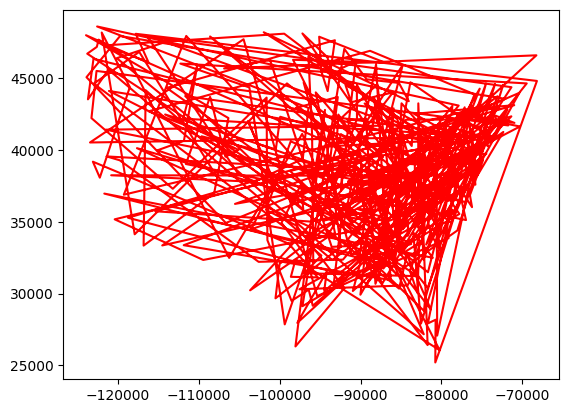

In [34]:
sbt = sorted_by_tour(means, cluster_sequence)
plt.plot(sbt[:, 0], sbt[:, 1], 'r')
plt.show()

In [35]:
flips=1
passes = 0
max_passes = 10000
print("Uncrossing Edges: # Initial Tour Length =", tour_length(means, cluster_sequence))
while flips > 0 and passes < max_passes:
    flips = matthew_uncross_edges(means, cluster_sequence)
    passes += 1
    print("# Pass", passes, "(" + str(flips) + " flips)   Tour Length =", tour_length(means, cluster_sequence))
r_i+=1

Uncrossing Edges: # Initial Tour Length = 4906349.6635751175
# Pass 1 (460 flips)   Tour Length = 3602165.6353127277
# Pass 2 (426 flips)   Tour Length = 2780095.7090541073
# Pass 3 (384 flips)   Tour Length = 2040742.9469937885
# Pass 4 (324 flips)   Tour Length = 1544239.4430285299
# Pass 5 (289 flips)   Tour Length = 1218762.7310329403
# Pass 6 (238 flips)   Tour Length = 977314.3011857142
# Pass 7 (187 flips)   Tour Length = 813664.9877834886
# Pass 8 (133 flips)   Tour Length = 713432.5714154853
# Pass 9 (89 flips)   Tour Length = 655146.472863059
# Pass 10 (43 flips)   Tour Length = 626709.1889413309
# Pass 11 (17 flips)   Tour Length = 613330.2293990732
# Pass 12 (8 flips)   Tour Length = 610021.2747341839
# Pass 13 (5 flips)   Tour Length = 608848.6050710578
# Pass 14 (2 flips)   Tour Length = 608179.1523882631
# Pass 15 (0 flips)   Tour Length = 608179.1523882631


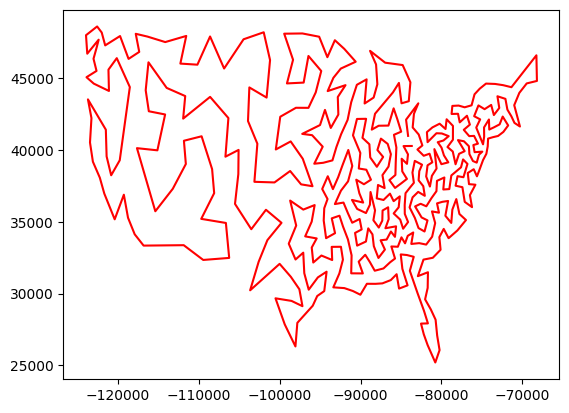

In [36]:
sbt = sorted_by_tour(means, cluster_sequence)
plt.plot(sbt[:, 0], sbt[:, 1], 'r')
plt.show()

In [38]:
tours_ordered = []
for i in range(0, len(cluster_sequence)):
    tours_ordered.append(tours[cluster_sequence[i]])

In [39]:
regions_ordered = []
for i in range(0, len(cluster_sequence)):
    regions_ordered.append(regions[cluster_sequence[i]])

In [40]:
raw_tours_ordered = []
for i in range(0, len(tours_ordered)):
    raw_tour = []
    for j in range(0, len(tours_ordered[i])):
        raw_tour.append(regions_ordered[i][j])
    raw_tours_ordered.append(raw_tour)

In [ ]:
new_starts = []
for i in range(0, len(raw_tours_ordered)-1)

In [827]:
start = time.time()
final_tour = concatenate_tours(tours, CITIES, regions)
print(time.time()-start, "seconds")
print(tour_length(CITIES, final_tour))

Concatenated 1 clusters
Concatenated 2 clusters
Concatenated 3 clusters
Concatenated 4 clusters
Concatenated 5 clusters
Concatenated 6 clusters
Concatenated 7 clusters
Concatenated 8 clusters
Concatenated 9 clusters
Concatenated 10 clusters
Concatenated 11 clusters
Concatenated 12 clusters
Concatenated 13 clusters
Concatenated 14 clusters
Concatenated 15 clusters
Concatenated 16 clusters
Concatenated 17 clusters
Concatenated 18 clusters
Concatenated 19 clusters
Concatenated 20 clusters
Concatenated 21 clusters
Concatenated 22 clusters
Concatenated 23 clusters
Concatenated 24 clusters
Concatenated 25 clusters
Concatenated 26 clusters
Concatenated 27 clusters
Concatenated 28 clusters
Concatenated 29 clusters
Concatenated 30 clusters
Concatenated 31 clusters
Concatenated 32 clusters
Concatenated 33 clusters
Concatenated 34 clusters
Concatenated 35 clusters
Concatenated 36 clusters
Concatenated 37 clusters
Concatenated 38 clusters
Concatenated 39 clusters
Concatenated 40 clusters
Concatena

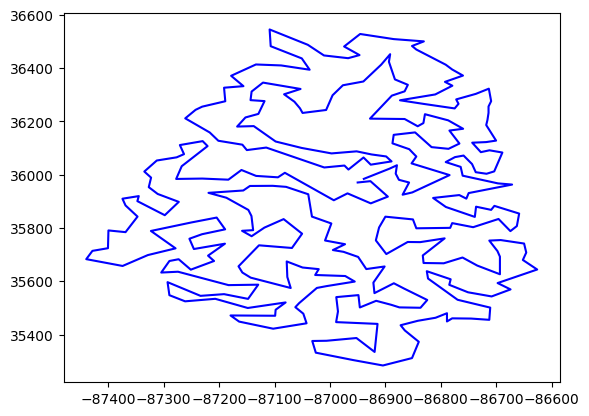

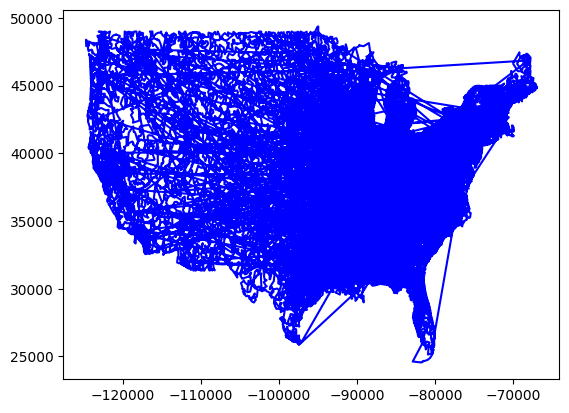

In [829]:
sbt = sorted_by_tour(regions[0], tours[0])
plt.plot(sbt[:, 0], sbt[:, 1], 'b')
plt.show()
sbt = sorted_by_tour(CITIES, final_tour)
plt.plot(sbt[:, 0], sbt[:, 1], 'b')
plt.show()

In [830]:
start = time.time()
r_i = 0
for tour in tours:
    flips=1
    passes = 0
    max_passes = 10000
    print("("+str(r_i)+") "+"Uncrossing Edges: # Initial Tour Length =", tour_length(regions[r_i], tour))
    while flips > 0 and passes < max_passes:
        flips = matthew_uncross_edges(regions[r_i], tour)
        passes += 1
        print("# Pass", passes, "(" + str(flips) + " flips)   Tour Length =", tour_length(regions[r_i], tour))
    r_i+=1
print(time.time()-start, "seconds")

(0) Uncrossing Edges: # Initial Tour Length = 13947.248707547831
# Pass 1 (0 flips)   Tour Length = 13947.248707547831
(1) Uncrossing Edges: # Initial Tour Length = 35106.97230879523
# Pass 1 (0 flips)   Tour Length = 35106.97230879523
(2) Uncrossing Edges: # Initial Tour Length = 19511.940216336836
# Pass 1 (0 flips)   Tour Length = 19511.940216336836
(3) Uncrossing Edges: # Initial Tour Length = 7826.570836735233
# Pass 1 (0 flips)   Tour Length = 7826.570836735233
(4) Uncrossing Edges: # Initial Tour Length = 24055.251116782543
# Pass 1 (0 flips)   Tour Length = 24055.251116782543
(5) Uncrossing Edges: # Initial Tour Length = 21985.766814337796
# Pass 1 (0 flips)   Tour Length = 21985.766814337796
(6) Uncrossing Edges: # Initial Tour Length = 29665.20290049992
# Pass 1 (0 flips)   Tour Length = 29665.20290049992
(7) Uncrossing Edges: # Initial Tour Length = 12057.003720543657
# Pass 1 (0 flips)   Tour Length = 12057.003720543657
(8) Uncrossing Edges: # Initial Tour Length = 19077.40

In [831]:
#concatenate tours together into final solution
start = time.time()
final_tour = concatenate_tours(tours, CITIES, regions)
print(time.time()-start, "seconds")

Concatenated 1 clusters
Concatenated 2 clusters
Concatenated 3 clusters
Concatenated 4 clusters
Concatenated 5 clusters
Concatenated 6 clusters
Concatenated 7 clusters
Concatenated 8 clusters
Concatenated 9 clusters
Concatenated 10 clusters
Concatenated 11 clusters
Concatenated 12 clusters
Concatenated 13 clusters
Concatenated 14 clusters
Concatenated 15 clusters
Concatenated 16 clusters
Concatenated 17 clusters
Concatenated 18 clusters
Concatenated 19 clusters
Concatenated 20 clusters
Concatenated 21 clusters
Concatenated 22 clusters
Concatenated 23 clusters
Concatenated 24 clusters
Concatenated 25 clusters
Concatenated 26 clusters
Concatenated 27 clusters
Concatenated 28 clusters
Concatenated 29 clusters
Concatenated 30 clusters
Concatenated 31 clusters
Concatenated 32 clusters
Concatenated 33 clusters
Concatenated 34 clusters
Concatenated 35 clusters
Concatenated 36 clusters
Concatenated 37 clusters
Concatenated 38 clusters
Concatenated 39 clusters
Concatenated 40 clusters
Concatena

In [832]:
print(tour_length(CITIES, final_tour))

11791646.624273654


## Ant Colony Optimization

In [50]:
import random
# from multiprocessing import Process
from threading import Thread

from joblib import Parallel, delayed

import defs #in order for multiprocessing to work using native libraries on jupyter notebook, need to import the parallelized function from a seperate file

#given a start city, alpha and beta, and the existing pheromones, returns a tour chosen by an ant with the given alpha beta
def traverse_graph(cities, pheromone_alpha, distance_beta, pheromone_map):
    visited = [] #acts both as cities visited and tour for ant
    visited.append(0) #the ant starts at the starting city (the first city)
    current = 0
    while len(visited) < len(cities): #while the tour hasn't reached every city
        neighbors = [] #feasible neighbors (neighbors we haven't already visited)
        neighbor_weights = [] #probability weight that ant chooses corresponding neighbor
        for i in range(0, len(cities)): #visit all possible cities
            if i not in visited: #if the city hasn't been visited
                pheromone = max(pheromone_map[current, i], 1e-5) #retrieve the pheromone along that edge, retrieving a minimal amount to encourage exploration
                weight = (pheromone**pheromone_alpha)/(dist(cities[current], cities[i])**distance_beta) #and use it and the distance to calculate the weight that the ant picks this city
                #add feasible neighbor and it's calculated weight to the list of possible next cities
                neighbors.append(i)
                neighbor_weights.append(weight)
        #randomly choose the next city
        next = random.choices(neighbors, weights = neighbor_weights)[0] #uses the normalized weights
        #update tour
        visited.append(next)
        current=next
    assert len(cities) == len(visited)
    return visited

# def parallel_traverse(cities, pheromone_alpha, distance_beta, pheromone_map, ants, j):
#     ant = traverse_graph(cities, pheromone_alpha, distance_beta, pheromone_map)
#     ants[j] = ant

#alpha and beta are hyperparameters for controlling the importantance of pheromone level and distance in calculating edge weight
#p_inverse is a hyperparameter for controlling the amount of pheromone placed into the pheromone map by a given ant
def ant_colony_optimization(cities, N, ant_num, pheromone_alpha, distance_beta, p_inverse, p_decay, print_stats):
    start = time.time()
    #Metrics
    super_duper_best_ant = []
    super_duper_best_ant_dist = sys.maxsize
    super_duper_best_ant_generation = 0
    best_per_gen = []
    worst_per_gen = []
    avg_per_gen = []

    #initializing empty pheromone map
    pheromone_map = np.zeros((len(cities), len(cities)))
    for i in range(0, N):
        ants = [] #every gen starts with fresh ants
        #per generation metrics
        best = sys.maxsize
        worst = 0
        avg = 0

        #parallel implementation of ant traversal
        #runs traverse_graph ant_num times with -2 threads (number of cpu threads - (1 - 2)) i.e. use all possible threads but leave one free
        ants = Parallel(n_jobs=-2)(delayed(traverse_graph)(cities, pheromone_alpha, distance_beta, pheromone_map) for ant in range(0, ant_num))

        # ant_threads = [None] * ant_num
        # ants_parallel = [None] * ant_num

        # for i in range(len(ant_threads)):
        #     ant_threads[i] = Thread(target=parallel_traverse)
        
        # ant_processes = []
        # if __name__ == '__main__':
        #     for j in range(0, ant_num):
        #         p = Process(target=defs.parallel_traverse, args=(cities, pheromone_alpha, distance_beta, pheromone_map, ants, j,)) 
        #         ant_processes.append(p)
        #         p.start() #starts the process in parallel for the current ant. This ant's found tour will be appended to ants when completed
        #     for t in ant_processes: #don't continue until all ants have finished traversing
        #         t.join()
        
        #sequential implementation of ant traversal
        
        # for j in range(0, ant_num):
        #     ant = traverse_graph(cities, pheromone_alpha, distance_beta, pheromone_map)
        #     ants.append(ant)

        #clear pheromone map (subject to degredation TODO)
        #pheromone_map = np.zeros((len(cities), len(cities)))

        #We don't clear the pheromone. Instead, we decay it
        for row in pheromone_map:
            for pheromone in row:
                pheromone = pheromone * (1 - p_decay)
        
        #have each ant lay their pheromone
        for ant in ants:
            dist = tour_length(cities, ant)
            pheromone = p_inverse/dist #calculates pheromone to add inversely prop to the distance, increasing with respect to p_inverse
            for j in range(0, len(ant)-1):
                pheromone_map[ant[j], ant[j+1]] += pheromone #adds the pheromones to the empty pheromone map
            #Metric Keeping
            if dist < best:
                best = dist
                if best < super_duper_best_ant_dist:
                    super_duper_best_ant_dist = best
                    super_duper_best_ant = ant
                    super_duper_best_ant_generation = i
                    if print_stats: print("Reset solution at gen " + str(i))
            if dist > worst:
                worst = dist
            avg += dist
        best_per_gen.append(best)
        worst_per_gen.append(worst)
        avg_per_gen.append(avg/ant_num)
    if print_stats:
        print(time.time()-start,"seconds")
        plt.plot(np.array(range(len(avg_per_gen))),avg_per_gen, label="Average per Gen")
        plt.plot(np.array(range(len(best_per_gen))),best_per_gen, c='g', label="Best per Gen")
        plt.plot(np.array(range(len(worst_per_gen))),worst_per_gen, c='r', label="Worst per Gen")
        plt.scatter(super_duper_best_ant_generation, super_duper_best_ant_dist, c='y', s=12, marker='o', label="Best Tour")
        plt.xlabel("Generations")
        plt.ylabel("Tour Length")
        plt.legend()
        plt.show()
        
        print("Best Tour Found in generation " + str(super_duper_best_ant_generation) + " with length of " + str(super_duper_best_ant_dist))
    return super_duper_best_ant

In [51]:
gens = 100 #number of generation of ants
ant_num = 10 #size of each generation of ants
#when calculating edge probability weights, pheromone is squared by alpha. 
#Thus, alpha > 1 is for a more exploitative approach of swarm ai, putting greater importance on the pheromone
#An alpha of < 1 is for a more exploratative approach, more likely to explore new paths. 
pheromone_alpha = 1
#when calculating edge probability weights, the inverse of the edge distance is squared by beta.
#Thus, a beta > 1 favors a greedy approach, increasing the importance of the heuristic a priori knowledge
#A beta < 1 then decreases the heuristic influence, allowing exploration of longer paths
distance_beta = 2
#when ants apply pheromone to an edge, p_inverse divided by the tour length is the calculation
#So, p_inverse represents the scale at which pheromone is applied
p_inverse = 10
p_decay = 0.8 #the percent at which pheromone decays every generation. A decay of 1 clears the pheromone map every generation.

print("Performing Ant Colony Optimization on Cluster Centroids")
cluster_sequence = ant_colony_optimization(regions[0], gens, ant_num, pheromone_alpha, distance_beta, p_inverse, p_decay, True)
print(cluster_sequence)
check_for_dups(cluster_sequence)
sbt = sorted_by_tour(means, cluster_sequence)
plt.plot(sbt[:, 0], sbt[:, 1], 'r')
plt.show()

Performing Ant Colony Optimization on Cluster Centroids


TypeError: 'numpy.int64' object is not callable

In [31]:
def greedy(cities):
    tour = []
    tour.append(0)
    for i in range(1, len(cities)):
        if i%10000==0: print(i/1000,"k")
        smallest_dist = sys.maxsize
        next = 0
        for j in range(1, len(cities)):
            if j not in tour:
                d = dist(cities[i-1], cities[j])
                if smallest_dist > d:
                    smallest_dist = d
                    tour.append(j)
    return tour

Performing Greedy on Cluster Centroids
[0, 1, 3, 4, 6, 38, 60, 62, 98, 2, 5, 8, 17, 53, 7, 9, 15, 108, 120, 10, 11, 22, 56, 106, 12, 13, 14, 23, 44, 123, 16, 54, 18, 28, 33, 49, 67, 144, 19, 20, 24, 21, 31, 32, 35, 36, 50, 52, 58, 59, 63, 77, 91, 25, 27, 29, 34, 37, 40, 64, 113, 26, 30, 39, 61, 134, 41, 46, 48, 51, 55, 66, 71, 94, 111, 42, 43, 45, 47, 73, 78, 57, 65, 68, 72, 74, 76, 79, 93, 96, 101, 109, 69, 75, 80, 82, 84, 70, 83, 85, 86, 81, 87, 88, 104, 114, 131, 89, 90, 121, 92, 95, 128, 97, 99, 112, 119, 129, 100, 102, 105, 110, 118, 125, 103, 115, 116, 117, 135, 141, 149, 107, 126, 122, 124, 127, 130, 132, 136, 133, 138, 137, 139, 145, 148, 140, 143, 142, 146, 147]
No duplicates exist. Tour is valid


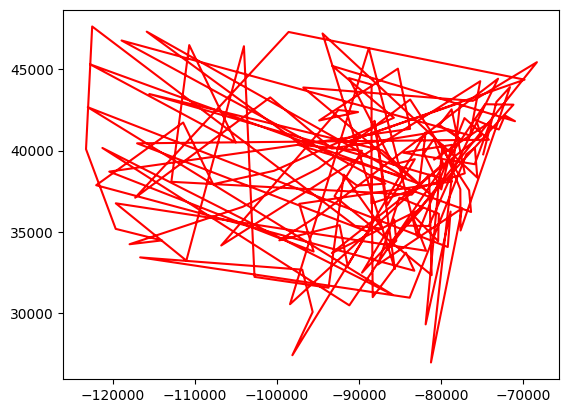

In [15]:
print("Performing Greedy on Cluster Centroids")
greedy_cluster_sequence = greedy(means)
print(greedy_cluster_sequence)
check_for_dups(greedy_cluster_sequence)
sbt = sorted_by_tour(means, greedy_cluster_sequence)
plt.plot(sbt[:, 0], sbt[:, 1], 'r')
plt.show()

() Uncrossing Edges: # Initial Tour Length = 586100.6642906456
# Pass 1 (65 flips)   Tour Length = 532317.1676667676
# Pass 2 (39 flips)   Tour Length = 506760.81968739274
# Pass 3 (27 flips)   Tour Length = 488635.4597009881
# Pass 4 (17 flips)   Tour Length = 474649.87451110577
# Pass 5 (8 flips)   Tour Length = 469890.0317710542
# Pass 6 (2 flips)   Tour Length = 467581.96349607164
# Pass 7 (2 flips)   Tour Length = 466831.5381866512
# Pass 8 (8 flips)   Tour Length = 463062.5518147934
# Pass 9 (1 flips)   Tour Length = 462612.0023887204
# Pass 10 (0 flips)   Tour Length = 462612.0023887204
0.9220240116119385 seconds


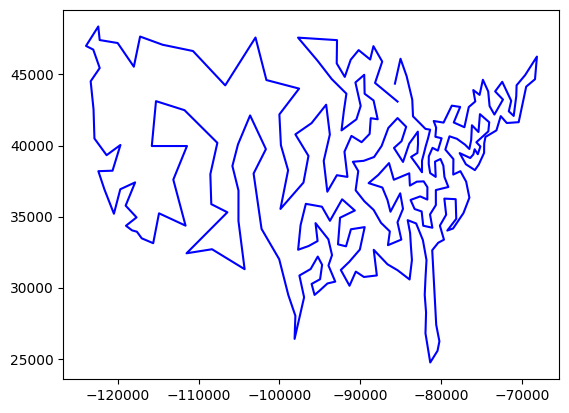

In [18]:
start = time.time()
flips=1
passes = 0
max_passes = 10000
print("("+") "+"Uncrossing Edges: # Initial Tour Length =", tour_length(means, cluster_sequence))
while flips > 0 and passes < max_passes:
    flips = matthew_uncross_edges(means, cluster_sequence)
    passes += 1
    print("# Pass", passes, "(" + str(flips) + " flips)   Tour Length =", tour_length(means, cluster_sequence))
print(time.time()-start, "seconds")
sbt = sorted_by_tour(means, cluster_sequence)
plt.plot(sbt[:, 0], sbt[:, 1], 'b')
plt.show()

(149) Uncrossing Edges: # Initial Tour Length = 1831012.0878358018
# Pass 1 (136 flips)   Tour Length = 1384296.426968863
# Pass 2 (115 flips)   Tour Length = 1093489.4826785526
# Pass 3 (103 flips)   Tour Length = 781648.4461707051
# Pass 4 (78 flips)   Tour Length = 604504.376230295
# Pass 5 (72 flips)   Tour Length = 482562.7434230959
# Pass 6 (49 flips)   Tour Length = 412226.65238706453
# Pass 7 (34 flips)   Tour Length = 362099.4465607754
# Pass 8 (16 flips)   Tour Length = 347384.12979007163
# Pass 9 (10 flips)   Tour Length = 334200.3429434344
# Pass 10 (0 flips)   Tour Length = 334200.3429434344
0.18432092666625977 seconds


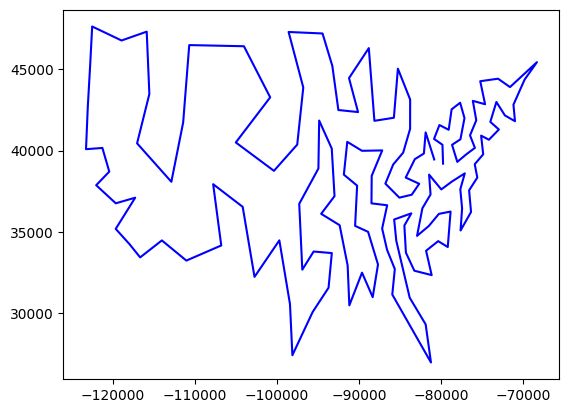

In [16]:
start = time.time()
flips=1
passes = 0
max_passes = 10000
print("("+str(r_i)+") "+"Uncrossing Edges: # Initial Tour Length =", tour_length(means, greedy_cluster_sequence))
while flips > 0 and passes < max_passes:
    flips = matthew_uncross_edges(means, greedy_cluster_sequence)
    passes += 1
    print("# Pass", passes, "(" + str(flips) + " flips)   Tour Length =", tour_length(means, greedy_cluster_sequence))
print(time.time()-start, "seconds")
sbt = sorted_by_tour(means, greedy_cluster_sequence)
plt.plot(sbt[:, 0], sbt[:, 1], 'b')
plt.show()

In [837]:
tours_ordered = []
for i in range(0, len(cluster_sequence)):
    tours_ordered.append(tours[cluster_sequence[i]])
tours_ordered

[array([183, 188, 178, 176, 195, 200,  63, 198, 197, 193,   1, 139,  18,
         46, 321, 216,  70, 220,  31, 324, 322, 214, 215,  39, 213,  81,
        120, 318, 157, 232,  60,  51, 312,  47, 110, 101,  26, 295,  89,
        246, 135,  34, 250,  93, 266, 308,  71, 236, 239, 237,   3, 121,
        108, 300, 228, 231, 230, 221, 189, 179, 140, 184, 160,  91,  85,
         50,  29, 209, 123, 132, 316, 207, 141,  28, 148, 261,   8, 168,
        111, 274, 126, 167,  11, 119, 150, 276,  58, 285,   5, 106, 166,
         49,  72,  78, 116, 137,  79,  13,  88,  65,  20, 225, 211, 219,
        229,  68, 134,  96, 154,  52, 227,  67,  66,  22, 224, 212, 210,
        233, 186, 180, 223, 218, 226, 222, 217, 196, 191, 190, 199, 252,
        268, 194,  98, 182, 177,  25, 181, 314,  86, 149, 296, 256, 109,
        292, 280, 264, 253, 323, 105,  82, 272, 271,  33, 287, 163, 293,
        258,   7,   0,  77, 305, 315, 133,  54, 278,  27, 265,  21, 267,
        313,  24, 290,  14, 162, 279,  15,  56, 301

In [20]:
regions_ordered = []
for i in range(0, len(cluster_sequence)):
    regions_ordered.append(regions[cluster_sequence[i]])

In [839]:
raw_tours_ordered = []
for i in range(0, len(tours_ordered)):
    raw_tour = []
    for j in range(0, len(tours_ordered[i])):
        raw_tour.append(regions_ordered[i][j])
    raw_tours_ordered.append(raw_tour)

In [840]:
new_starts = []
for raw_tour in raw_tours_ordered:
    longest_dist = 0
    new_start = 0
    for i in range(0, len(raw_tour)-1):
        if dist(raw_tour[i], raw_tour[i+1]) > longest_dist:
            longest_dist = dist(raw_tour[i], raw_tour[i+1])
            new_start = i
    new_starts.append(new_start)

In [841]:
rotated_tours = []
for i in range(0, len(tours_ordered)):
    new_tour = tours_ordered[i][new_starts[i]:].tolist() + tours_ordered[i][:new_starts[i]].tolist()
    rotated_tours.append(np.array(new_tour))

In [842]:
start = time.time()
final_tour = concatenate_tours(tours_ordered, CITIES, regions_ordered)
print(time.time()-start, "seconds")

Concatenated 1 clusters
Concatenated 2 clusters
Concatenated 3 clusters
Concatenated 4 clusters
Concatenated 5 clusters
Concatenated 6 clusters
Concatenated 7 clusters
Concatenated 8 clusters
Concatenated 9 clusters
Concatenated 10 clusters
Concatenated 11 clusters
Concatenated 12 clusters
Concatenated 13 clusters
Concatenated 14 clusters
Concatenated 15 clusters
Concatenated 16 clusters
Concatenated 17 clusters
Concatenated 18 clusters
Concatenated 19 clusters
Concatenated 20 clusters
Concatenated 21 clusters
Concatenated 22 clusters
Concatenated 23 clusters
Concatenated 24 clusters
Concatenated 25 clusters
Concatenated 26 clusters
Concatenated 27 clusters
Concatenated 28 clusters
Concatenated 29 clusters
Concatenated 30 clusters
Concatenated 31 clusters
Concatenated 32 clusters
Concatenated 33 clusters
Concatenated 34 clusters
Concatenated 35 clusters
Concatenated 36 clusters
Concatenated 37 clusters
Concatenated 38 clusters
Concatenated 39 clusters
Concatenated 40 clusters
Concatena

In [843]:
start = time.time()
final_tour_with_rotate = concatenate_tours(rotated_tours, CITIES, regions_ordered)
print(time.time()-start, "seconds")

Concatenated 1 clusters
Concatenated 2 clusters
Concatenated 3 clusters
Concatenated 4 clusters
Concatenated 5 clusters
Concatenated 6 clusters
Concatenated 7 clusters
Concatenated 8 clusters
Concatenated 9 clusters
Concatenated 10 clusters
Concatenated 11 clusters
Concatenated 12 clusters
Concatenated 13 clusters
Concatenated 14 clusters
Concatenated 15 clusters
Concatenated 16 clusters
Concatenated 17 clusters
Concatenated 18 clusters
Concatenated 19 clusters
Concatenated 20 clusters
Concatenated 21 clusters
Concatenated 22 clusters
Concatenated 23 clusters
Concatenated 24 clusters
Concatenated 25 clusters
Concatenated 26 clusters
Concatenated 27 clusters
Concatenated 28 clusters
Concatenated 29 clusters
Concatenated 30 clusters
Concatenated 31 clusters
Concatenated 32 clusters
Concatenated 33 clusters
Concatenated 34 clusters
Concatenated 35 clusters
Concatenated 36 clusters
Concatenated 37 clusters
Concatenated 38 clusters
Concatenated 39 clusters
Concatenated 40 clusters
Concatena

In [844]:
print(tour_length(CITIES, final_tour))
print(tour_length(CITIES, final_tour_with_rotate))

7694815.21060751
7673970.592998496


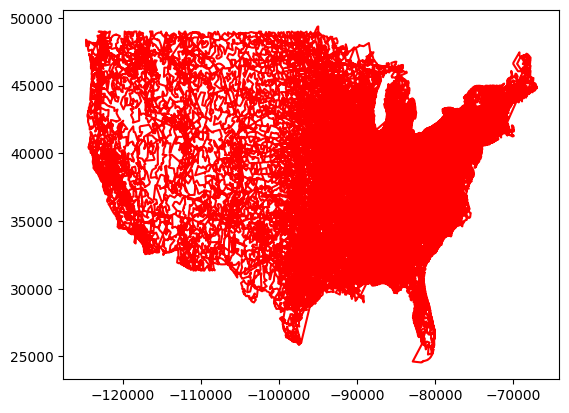

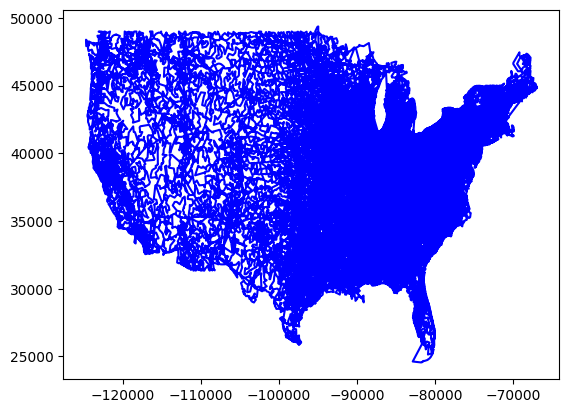

In [845]:
sbt = sorted_by_tour(CITIES, final_tour)
plt.plot(sbt[:, 0], sbt[:, 1], 'r')
plt.show()
sbt = sorted_by_tour(CITIES, final_tour_with_rotate)
plt.plot(sbt[:, 0], sbt[:, 1], 'b')
plt.show()

Reset solution at gen 0
Reset solution at gen 0
Reset solution at gen 3
Reset solution at gen 3
Reset solution at gen 3
Reset solution at gen 7
Reset solution at gen 8
Reset solution at gen 9
Reset solution at gen 9
Reset solution at gen 10
Reset solution at gen 11
Reset solution at gen 11
Reset solution at gen 11
Reset solution at gen 12
Reset solution at gen 13
Reset solution at gen 14
Reset solution at gen 14
Reset solution at gen 16
Reset solution at gen 18
Reset solution at gen 20
Reset solution at gen 24
Reset solution at gen 26
Reset solution at gen 27
Reset solution at gen 31
Reset solution at gen 36
Reset solution at gen 37
Reset solution at gen 38
Reset solution at gen 41
Reset solution at gen 41
Reset solution at gen 43
Reset solution at gen 44
Reset solution at gen 48
Reset solution at gen 48
Reset solution at gen 54
Reset solution at gen 54
Reset solution at gen 59
Reset solution at gen 82
Reset solution at gen 90
Reset solution at gen 95
30.235305070877075 seconds


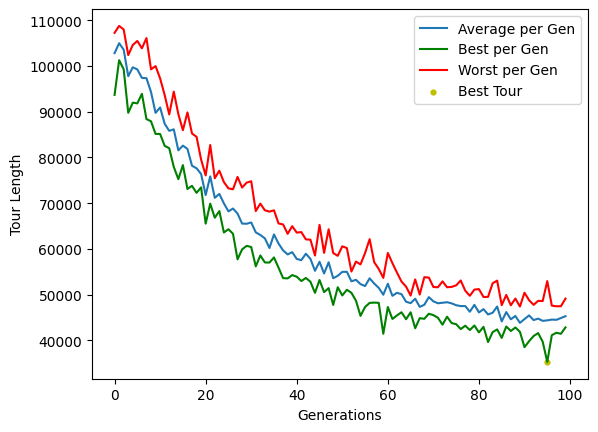

Best Tour Found in generation 95 with length of 35284.01110914876


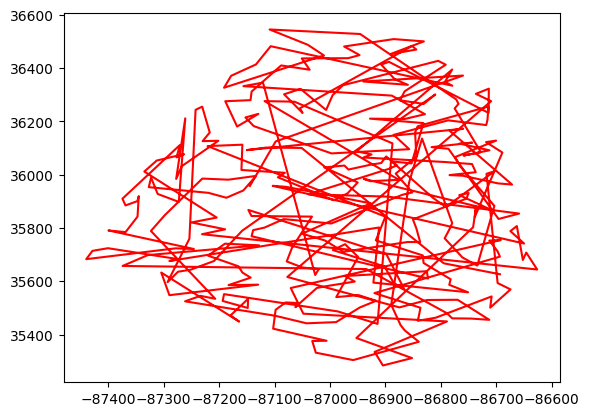

In [942]:
gens = 100 #number of generation of ants
ant_num = 10 #size of each generation of ants
#when calculating edge probability weights, pheromone is squared by alpha. 
#Thus, alpha > 1 is for a more exploitative approach of swarm ai, putting greater importance on the pheromone
#An alpha of < 1 is for a more exploratative approach, more likely to explore new paths. 
pheromone_alpha = 0.75
#when calculating edge probability weights, the inverse of the edge distance is squared by beta.
#Thus, a beta > 1 favors a greedy approach, increasing the importance of the heuristic a priori knowledge
#A beta < 1 then decreases the heuristic influence, allowing exploration of longer paths
distance_beta = 1
#when ants apply pheromone to an edge, p_inverse divided by the tour length is the calculation
#So, p_inverse represents the scale at which pheromone is applied
p_inverse = 1
p_decay = 0.8 #the percent at which pheromone decays every generation. A decay of 1 clears the pheromone map every generation.

aco_tour = ant_colony_optimization(regions[0], gens, ant_num, pheromone_alpha, distance_beta, p_inverse, p_decay)
sbt = sorted_by_tour(regions[0], aco_tour)
plt.plot(sbt[:, 0], sbt[:, 1], 'r')
plt.show()

In [47]:
gens = 100 #number of generation of ants
ant_num = 5 #size of each generation of ants
#when calculating edge probability weights, pheromone is squared by alpha. 
#Thus, alpha > 1 is for a more exploitative approach of swarm ai, putting greater importance on the pheromone
#An alpha of < 1 is for a more exploratative approach, more likely to explore new paths. 
pheromone_alpha = 0.75
#when calculating edge probability weights, the inverse of the edge distance is squared by beta.
#Thus, a beta > 1 favors a greedy approach, increasing the importance of the heuristic a priori knowledge
#A beta < 1 then decreases the heuristic influence, allowing exploration of longer paths
distance_beta = 1
#when ants apply pheromone to an edge, p_inverse divided by the tour length is the calculation
#So, p_inverse represents the scale at which pheromone is applied
p_inverse = 1
p_decay = 0.8 #the percent at which pheromone decays every generation. A decay of 1 clears the pheromone map every generation.



aco_tours = []
t_i = 0
start_time = time.time()
for reg in regions:
    n_r_i = len(reg)
    print("Running ant colony optimization on cluster " + str(t_i) + " with " + str(n_r_i) + " cities")
    t = ant_colony_optimization(reg, gens, ant_num, pheromone_alpha, distance_beta, p_inverse, p_decay, True)
    tours.append(t)
    print("Completed sub-tour for cluster number " + str(t_i) + " ---------------------------------------------------------------------")
    t_i+=1
print(time.time()-start, "seconds")

Running ant colony optimization on cluster 0 with 178 cities


TypeError: 'numpy.int64' object is not callable

In [857]:
#oops accidently appended to the wrong array - quick fix
print(len(tours))

600


In [855]:
for i in range(300, 600):
    aco_tours.append(tours[i])

In [858]:
tours = tours[:300]

In [859]:
print(len(tours))
print(len(aco_tours))

300
300


In [860]:
start = time.time()
r_i = 0
for tour in aco_tours:
    flips=1
    passes = 0
    max_passes = 10000
    print("("+str(r_i)+") "+"Uncrossing Edges: # Initial Tour Length =", tour_length(regions[r_i], tour))
    while flips > 0 and passes < max_passes:
        flips = matthew_uncross_edges(regions[r_i], tour)
        passes += 1
        print("# Pass", passes, "(" + str(flips) + " flips)   Tour Length =", tour_length(regions[r_i], tour))
    r_i+=1
print(time.time()-start, "seconds")

(0) Uncrossing Edges: # Initial Tour Length = 46946.071593112785
# Pass 1 (205 flips)   Tour Length = 38545.18459270714
# Pass 2 (185 flips)   Tour Length = 29121.708178370198
# Pass 3 (137 flips)   Tour Length = 23756.278732075087
# Pass 4 (119 flips)   Tour Length = 19815.21139125945
# Pass 5 (86 flips)   Tour Length = 17381.320912684016
# Pass 6 (63 flips)   Tour Length = 15525.177700507984
# Pass 7 (37 flips)   Tour Length = 14816.33474445209
# Pass 8 (17 flips)   Tour Length = 14446.901745548541
# Pass 9 (11 flips)   Tour Length = 14224.286533180884
# Pass 10 (2 flips)   Tour Length = 14200.017993135565
# Pass 11 (1 flips)   Tour Length = 14183.310181442734
# Pass 12 (0 flips)   Tour Length = 14183.310181442734
(1) Uncrossing Edges: # Initial Tour Length = 309176.6677573035
# Pass 1 (621 flips)   Tour Length = 231548.73094812265
# Pass 2 (578 flips)   Tour Length = 174218.4895737001
# Pass 3 (519 flips)   Tour Length = 131336.4870453743
# Pass 4 (476 flips)   Tour Length = 98065.5

In [861]:
aco_tours_ordered = []
for i in range(0, len(cluster_sequence)):
    aco_tours_ordered.append(aco_tours[cluster_sequence[i]])

In [862]:
raw_aco_tours_ordered = []
for i in range(0, len(aco_tours_ordered)):
    raw_tour = []
    for j in range(0, len(aco_tours_ordered[i])):
        raw_tour.append(regions_ordered[i][j])
    raw_aco_tours_ordered.append(raw_tour)

In [863]:
new_aco_starts = []
for raw_tour in raw_aco_tours_ordered:
    longest_dist = 0
    new_start = 0
    for i in range(0, len(raw_tour)-1):
        if dist(raw_tour[i], raw_tour[i+1]) > longest_dist:
            longest_dist = dist(raw_tour[i], raw_tour[i+1])
            new_start = i
    new_aco_starts.append(new_start)

In [865]:
rotated_aco_tours = []
for i in range(0, len(aco_tours_ordered)):
    new_tour = aco_tours_ordered[i][new_aco_starts[i]:] + aco_tours_ordered[i][:new_aco_starts[i]]
    rotated_aco_tours.append(np.array(new_tour))

In [866]:
start = time.time()
final_aco_tour = concatenate_tours(aco_tours_ordered, CITIES, regions_ordered)
print(time.time()-start, "seconds")

Concatenated 1 clusters
Concatenated 2 clusters
Concatenated 3 clusters
Concatenated 4 clusters
Concatenated 5 clusters
Concatenated 6 clusters
Concatenated 7 clusters
Concatenated 8 clusters
Concatenated 9 clusters
Concatenated 10 clusters
Concatenated 11 clusters
Concatenated 12 clusters
Concatenated 13 clusters
Concatenated 14 clusters
Concatenated 15 clusters
Concatenated 16 clusters
Concatenated 17 clusters
Concatenated 18 clusters
Concatenated 19 clusters
Concatenated 20 clusters
Concatenated 21 clusters
Concatenated 22 clusters
Concatenated 23 clusters
Concatenated 24 clusters
Concatenated 25 clusters
Concatenated 26 clusters
Concatenated 27 clusters
Concatenated 28 clusters
Concatenated 29 clusters
Concatenated 30 clusters
Concatenated 31 clusters
Concatenated 32 clusters
Concatenated 33 clusters
Concatenated 34 clusters
Concatenated 35 clusters
Concatenated 36 clusters
Concatenated 37 clusters
Concatenated 38 clusters
Concatenated 39 clusters
Concatenated 40 clusters
Concatena

In [867]:
start = time.time()
final_aco_tour_with_rotate = concatenate_tours(rotated_aco_tours, CITIES, regions_ordered)
print(time.time()-start, "seconds")

Concatenated 1 clusters
Concatenated 2 clusters
Concatenated 3 clusters
Concatenated 4 clusters
Concatenated 5 clusters
Concatenated 6 clusters
Concatenated 7 clusters
Concatenated 8 clusters
Concatenated 9 clusters
Concatenated 10 clusters
Concatenated 11 clusters
Concatenated 12 clusters
Concatenated 13 clusters
Concatenated 14 clusters
Concatenated 15 clusters
Concatenated 16 clusters
Concatenated 17 clusters
Concatenated 18 clusters
Concatenated 19 clusters
Concatenated 20 clusters
Concatenated 21 clusters
Concatenated 22 clusters
Concatenated 23 clusters
Concatenated 24 clusters
Concatenated 25 clusters
Concatenated 26 clusters
Concatenated 27 clusters
Concatenated 28 clusters
Concatenated 29 clusters
Concatenated 30 clusters
Concatenated 31 clusters
Concatenated 32 clusters
Concatenated 33 clusters
Concatenated 34 clusters
Concatenated 35 clusters
Concatenated 36 clusters
Concatenated 37 clusters
Concatenated 38 clusters
Concatenated 39 clusters
Concatenated 40 clusters
Concatena

In [868]:
print(tour_length(CITIES, final_aco_tour))
print(tour_length(CITIES, final_aco_tour_with_rotate))

7681484.8133489415
7672426.625116794


In [21]:
import contextlib
from tqdm import tqdm
import joblib

@contextlib.contextmanager
def tqdm_joblib(tqdm_object):
    """Context manager to patch joblib to report into tqdm progress bar given as argument"""
    class TqdmBatchCompletionCallback(joblib.parallel.BatchCompletionCallBack):
        def __call__(self, *args, **kwargs):
            tqdm_object.update(n=self.batch_size)
            return super().__call__(*args, **kwargs)

    old_batch_callback = joblib.parallel.BatchCompletionCallBack
    joblib.parallel.BatchCompletionCallBack = TqdmBatchCompletionCallback
    try:
        yield tqdm_object
    finally:
        joblib.parallel.BatchCompletionCallBack = old_batch_callback
        tqdm_object.close()

In [1]:
#parameters for running on all clusters
gens = 1
darwin = .50 
mutate_chance_child = .35 
mutate_chance_elite = .75
population_size = 100 
elite_clone_percent = .35/darwin
messiah_margin = 100 
messiah_percent = .50
messiah_num = int(messiah_percent * population_size)

tours = []

start=time.time()
with tqdm_joblib(tqdm(desc="My calculation", total=len(regions))) as progress_bar:
    tours = Parallel(n_jobs=-2)(delayed(genetic_algorithm)(regions[i], 
                                                           generate_random_population(population_size, len(regions[i])),
                                                           gens, 
                                                           darwin, 
                                                           mutate_chance_child, 
                                                           mutate_chance_elite, 
                                                           population_size, 
                                                           elite_clone_percent, 
                                                           messiah_margin, 
                                                           messiah_num, 
                                                           False) for i in range(0, len(regions)))
print(time.time()-start, "seconds")

NameError: name 'time' is not defined

In [136]:
def uncross(tour, regions, r_i, p):
    flips=1
    passes = 0
    max_passes = 10000
    if p: print("("+str(r_i)+") "+"Uncrossing Edges: # Initial Tour Length =", tour_length(regions[r_i], tour))
    while flips > 0 and passes < max_passes:
        flips = matthew_uncross_edges(regions[r_i], tour)
        passes += 1
        if p: print("# Pass", passes, "(" + str(flips) + " flips)   Tour Length =", tour_length(regions[r_i], tour))

In [44]:
start = time.time()
parallel_genetic_tours = []
with tqdm_joblib(tqdm(desc="My calculation", total=len(regions))) as progress_bar:
    parallel_genetic_tours = Parallel(n_jobs=-2)(delayed(uncross)(tours[i], regions, i, False) for i in range(0, len(tours)))
print(time.time()-start, "seconds")


My calculation: 100%|█████████████████████████| 300/300 [03:02<00:00,  1.64it/s]

182.61302399635315 seconds


In [75]:
tours_ordered = []
for i in range(0, len(cluster_sequence)):
    tours_ordered.append(parallel_genetic_tours[cluster_sequence[i]])
raw_tours_ordered = []
for i in range(0, len(tours_ordered)):
    raw_tour = []
    for j in range(0, len(tours_ordered[i])):
        raw_tour.append(regions_ordered[i][j])
    raw_tours_ordered.append(raw_tour)
new_starts = []
for raw_tour in raw_tours_ordered:
    longest_dist = 0
    new_start = 0
    for i in range(0, len(raw_tour)-1):
        if dist(raw_tour[i], raw_tour[i+1]) > longest_dist:
            longest_dist = dist(raw_tour[i], raw_tour[i+1])
            new_start = i
    new_starts.append(new_start)
rotated_tours = []
for i in range(0, len(tours_ordered)):
    new_tour = tours_ordered[i][new_starts[i]:].tolist() + tours_ordered[i][:new_starts[i]].tolist()
    rotated_tours.append(np.array(new_tour))

TypeError: object of type 'NoneType' has no len()

In [33]:
start = time.time()
final_aco_tour_with_rotate = concatenate_tours(rotated_tours, CITIES, regions_ordered)
print(time.time()-start, "seconds")

Concatenated 1 clusters
Concatenated 2 clusters
Concatenated 3 clusters
Concatenated 4 clusters
Concatenated 5 clusters
Concatenated 6 clusters
Concatenated 7 clusters
Concatenated 8 clusters
Concatenated 9 clusters
Concatenated 10 clusters
Concatenated 11 clusters
Concatenated 12 clusters
Concatenated 13 clusters
Concatenated 14 clusters
Concatenated 15 clusters
Concatenated 16 clusters
Concatenated 17 clusters
Concatenated 18 clusters
Concatenated 19 clusters
Concatenated 20 clusters
Concatenated 21 clusters
Concatenated 22 clusters
Concatenated 23 clusters
Concatenated 24 clusters
Concatenated 25 clusters
Concatenated 26 clusters
Concatenated 27 clusters
Concatenated 28 clusters
Concatenated 29 clusters
Concatenated 30 clusters
Concatenated 31 clusters
Concatenated 32 clusters
Concatenated 33 clusters
Concatenated 34 clusters
Concatenated 35 clusters
Concatenated 36 clusters
Concatenated 37 clusters
Concatenated 38 clusters
Concatenated 39 clusters
Concatenated 40 clusters
Concatena

In [34]:
print(tour_length(CITIES, final_aco_tour_with_rotate))

52057593.97810085


In [ ]:
gens = 100 #number of generation of ants
ant_num = 5 #size of each generation of ants
#when calculating edge probability weights, pheromone is squared by alpha. 
#Thus, alpha > 1 is for a more exploitative approach of swarm ai, putting greater importance on the pheromone
#An alpha of < 1 is for a more exploratative approach, more likely to explore new paths. 
pheromone_alpha = 0.75
#when calculating edge probability weights, the inverse of the edge distance is squared by beta.
#Thus, a beta > 1 favors a greedy approach, increasing the importance of the heuristic a priori knowledge
#A beta < 1 then decreases the heuristic influence, allowing exploration of longer paths
distance_beta = 1
#when ants apply pheromone to an edge, p_inverse divided by the tour length is the calculation
#So, p_inverse represents the scale at which pheromone is applied
p_inverse = 1
p_decay = 0.8 #the percent at which pheromone decays every generation. A decay of 1 clears the pheromone map every generation.



start = time.time()
greater_clustered_parallel_aco_tours = []
with tqdm_joblib(tqdm(desc="My calculation", total=len(regions))) as progress_bar:
    greater_clustered_parallel_aco_tours = Parallel(n_jobs=-2)(delayed(ant_colony_optimization)(regions[i], gens, ant_num, pheromone_alpha, distance_beta, p_inverse, p_decay, False) for i in range(0, len(regions)))
print(time.time()-start, "seconds")

My calculation:   0%|                                   | 0/150 [00:00<?, ?it/s]

In [130]:
start = time.time()
parallel_aco_tours = []
with tqdm_joblib(tqdm(desc="My calculation", total=len(regions))) as progress_bar:
    Parallel(n_jobs=-2)(delayed(uncross)(greater_clustered_parallel_aco_tours[i], regions, i, False) for i in range(0, len(regions)))
print(time.time()-start, "seconds")

My calculation:   0%|                                   | 0/150 [00:00<?, ?it/s]


IndexError: list index out of range

In [97]:
for i in range(len(greater_clustered_parallel_aco_tours)):
    if i%10==0: print(i, "/500")
    uncross(greater_clustered_parallel_aco_tours[i], regions, i, False)

0 /500
10 /500
20 /500
30 /500
40 /500
50 /500
60 /500
70 /500
80 /500
90 /500
100 /500
110 /500
120 /500
130 /500
140 /500
150 /500
160 /500
170 /500
180 /500
190 /500
200 /500
210 /500
220 /500
230 /500
240 /500
250 /500
260 /500
270 /500
280 /500
290 /500
300 /500
310 /500
320 /500
330 /500
340 /500
350 /500
360 /500
370 /500
380 /500
390 /500
400 /500
410 /500
420 /500
430 /500
440 /500
450 /500
460 /500
470 /500
480 /500
490 /500


In [104]:
regions_ordered = []
for i in range(0, len(greedy_cluster_sequence)):
    regions_ordered.append(regions[greedy_cluster_sequence[i]])
tours_ordered = []
for i in range(0, len(greedy_cluster_sequence)):
    tours_ordered.append(greater_clustered_parallel_aco_tours[greedy_cluster_sequence[i]])
raw_tours_ordered = []
for i in range(0, len(tours_ordered)):
    raw_tour = []
    for j in range(0, len(tours_ordered[i])):
        raw_tour.append(regions_ordered[i][j])
    raw_tours_ordered.append(raw_tour)
new_starts = []
for raw_tour in raw_tours_ordered:
    longest_dist = 0
    new_start = 0
    for i in range(0, len(raw_tour)-1):
        if dist(raw_tour[i], raw_tour[i+1]) > longest_dist:
            longest_dist = dist(raw_tour[i], raw_tour[i+1])
            new_start = i
    new_starts.append(new_start)
rotated_tours = []
for i in range(0, len(tours_ordered)):
    new_tour = tours_ordered[i][new_starts[i]:] + tours_ordered[i][:new_starts[i]]
    rotated_tours.append(np.array(new_tour))

In [105]:
start = time.time()
final_parallel_aco_tour_with_rotate = concatenate_tours(rotated_tours, CITIES, regions_ordered)
print(time.time()-start, "seconds")

Concatenated 1 clusters
Concatenated 2 clusters
Concatenated 3 clusters
Concatenated 4 clusters
Concatenated 5 clusters
Concatenated 6 clusters
Concatenated 7 clusters
Concatenated 8 clusters
Concatenated 9 clusters
Concatenated 10 clusters
Concatenated 11 clusters
Concatenated 12 clusters
Concatenated 13 clusters
Concatenated 14 clusters
Concatenated 15 clusters
Concatenated 16 clusters
Concatenated 17 clusters
Concatenated 18 clusters
Concatenated 19 clusters
Concatenated 20 clusters
Concatenated 21 clusters
Concatenated 22 clusters
Concatenated 23 clusters
Concatenated 24 clusters
Concatenated 25 clusters
Concatenated 26 clusters
Concatenated 27 clusters
Concatenated 28 clusters
Concatenated 29 clusters
Concatenated 30 clusters
Concatenated 31 clusters
Concatenated 32 clusters
Concatenated 33 clusters
Concatenated 34 clusters
Concatenated 35 clusters
Concatenated 36 clusters
Concatenated 37 clusters
Concatenated 38 clusters
Concatenated 39 clusters
Concatenated 40 clusters
Concatena

In [106]:
print(tour_length(CITIES, final_parallel_aco_tour_with_rotate))

7844994.016491933
